<a href="https://www.kaggle.com/code/poiyut/customer-churn-classification?scriptVersionId=178364387" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!python --version

Python 3.10.13


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance


import xgboost
import lightgbm as lgb
import catboost

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import optuna
import shap

2024-05-18 09:45:57.950554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 09:45:57.950717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 09:45:58.106297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TRIALS = 30

# Загрузка данных

In [4]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv', index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


`Columns Description:`

- *`Customer ID:` A unique identifier for each customer*
- *`Surname:` The customer's surname or last name*
- *`Credit Score:` A numerical value representing the customer's credit score*
- *`Geography:` The country where the customer resides (France, Spain or Germany)*
- *`Gender:` The customer's gender (Male or Female)*
- *`Age:` The customer's age.*
- *`Tenure:` The number of years the customer has been with the bank*
- *`Balance:` The customer's account balance*
- *`NumOfProducts:` The number of bank products the customer uses (e.g., savings account, credit card)*
- *`HasCrCard:` Whether the customer has a credit card (1 = yes, 0 = no)*
- *`IsActiveMember:` Whether the customer is an active member (1 = yes, 0 = no)*
- *`EstimatedSalary:` The estimated salary of the customer*

`Target Column:`
- *`Exited:` Whether the customer has churned (1 = yes, 0 = no)*

In [5]:
df.shape

(10000, 13)

In [6]:
df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

# Исследовательский анализ данных

проверка на дубликаты и пропуски

In [7]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
df.duplicated().sum()

0

Базовая информация о данных

In [9]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [10]:
df = df.drop(columns=['CustomerId','Surname'])

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


* кредитный рейтинг варьируется от 350 до 850, и в среднем равен 650
* средний возраст 39 лет, диапазон от 18 до 92
* средняя продолжительность пользования услугами 5 лет
* средний баланс счета 76485, максимальный 250898, у 36% нулевой баланс
* у большинства клиентов один продукт
* 70% имеют кредитную карту
* 48.5% клиентов не активные, то есть не совершали операций за последние 3 месяца
* оценочная зарплата в диапазоне от 12 до 199992, средняя 100090

In [12]:
print(df['Exited'].value_counts().to_frame())
print('Процент ушедших клиентов: {:.2%}'.format(df['Exited'].mean()))

        count
Exited       
0        7963
1        2037
Процент ушедших клиентов: 20.37%


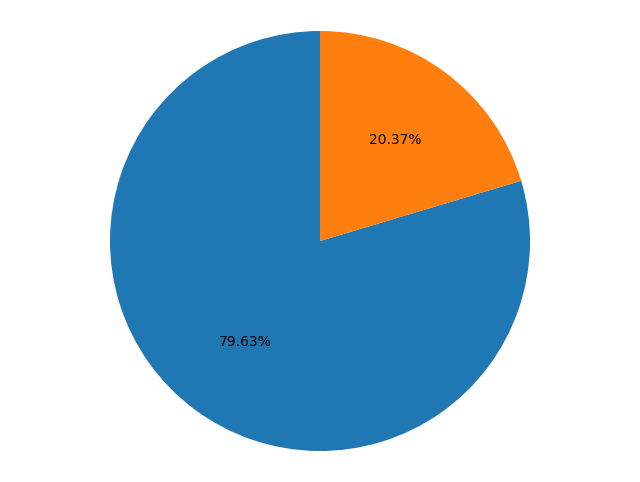

In [13]:
exit_counts = df['Exited'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(exit_counts,  autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.show()

Анализ в группировке по целевой переменной

In [14]:
df[df['Exited']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,7963.0,651.853196,95.653837,405.00,585.00,653.00,718.000,850.00
Age,7963.0,37.408389,10.125363,18.00,31.00,36.00,41.000,92.00
Tenure,7963.0,5.033279,2.880658,0.00,3.00,5.00,7.000,10.00
Balance,7963.0,72745.296779,62848.040701,0.00,0.00,92072.68,126410.280,221532.80
NumOfProducts,7963.0,1.544267,0.509536,1.00,1.00,2.00,2.000,3.00
HasCrCard,7963.0,0.707146,0.455101,0.00,0.00,1.00,1.000,1.00
IsActiveMember,7963.0,0.554565,0.497045,0.00,0.00,1.00,1.000,1.00
EstimatedSalary,7963.0,99738.391772,57405.586966,90.07,50783.49,99645.04,148609.955,199992.48
Exited,7963.0,0.000000,0.000000,0.00,0.00,0.00,0.000,0.00


In [15]:
df[df['Exited']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,2037.0,645.351497,100.321503,350.00,578.00,646.00,716.00,850.00
Age,2037.0,44.837997,9.761562,18.00,38.00,45.00,51.00,84.00
Tenure,2037.0,4.932744,2.936106,0.00,2.00,5.00,8.00,10.00
Balance,2037.0,91108.539337,58360.794816,0.00,38340.02,109349.29,131433.33,250898.09
NumOfProducts,2037.0,1.475209,0.801521,1.00,1.00,1.00,2.00,4.00
HasCrCard,2037.0,0.699067,0.458776,0.00,0.00,1.00,1.00,1.00
IsActiveMember,2037.0,0.360825,0.480358,0.00,0.00,0.00,1.00,1.00
EstimatedSalary,2037.0,101465.677531,57912.418071,11.58,51907.72,102460.84,152422.91,199808.10
Exited,2037.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00


у ушедших клиентов:
* кредитный рейтинг, период пользования, владение кредитной картой мало различается
* выше средний возраст 44.8 против 37.4
* выше средний баланс 91108 против 72745
* количество продуктов имеет большее стандартное отклонение 0.8 против 0.5 
* 36% активные по сравнению с 55% среди оставшихся

у оставшихся:
* CreditScore >= 405 
* баланс < 221533

Визуализация исследовательского анализа

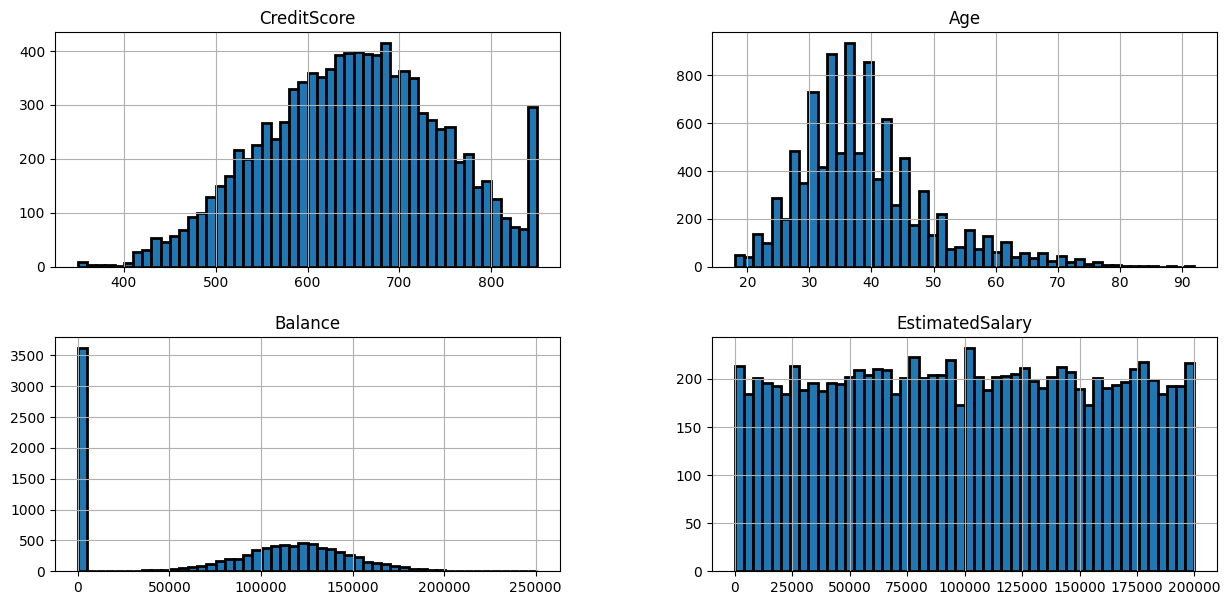

In [16]:
df[['CreditScore','Age','Balance','EstimatedSalary']].hist(bins=50, figsize=(15,7), edgecolor='black', linewidth=2)
plt.show()

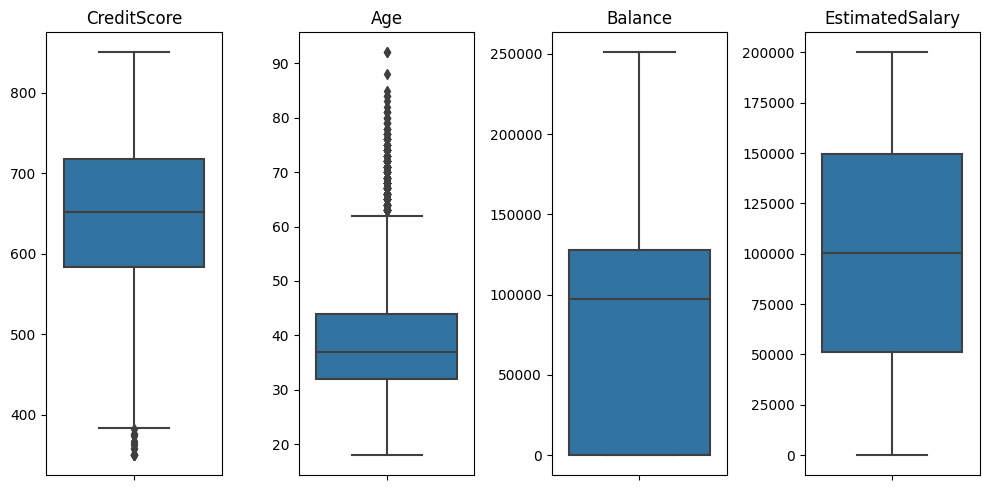

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

cols = ['CreditScore','Age','Balance','EstimatedSalary']

for ax, col in zip(axes, cols):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'{col}')
    ax.set_ylabel(None)

for ax in axes[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

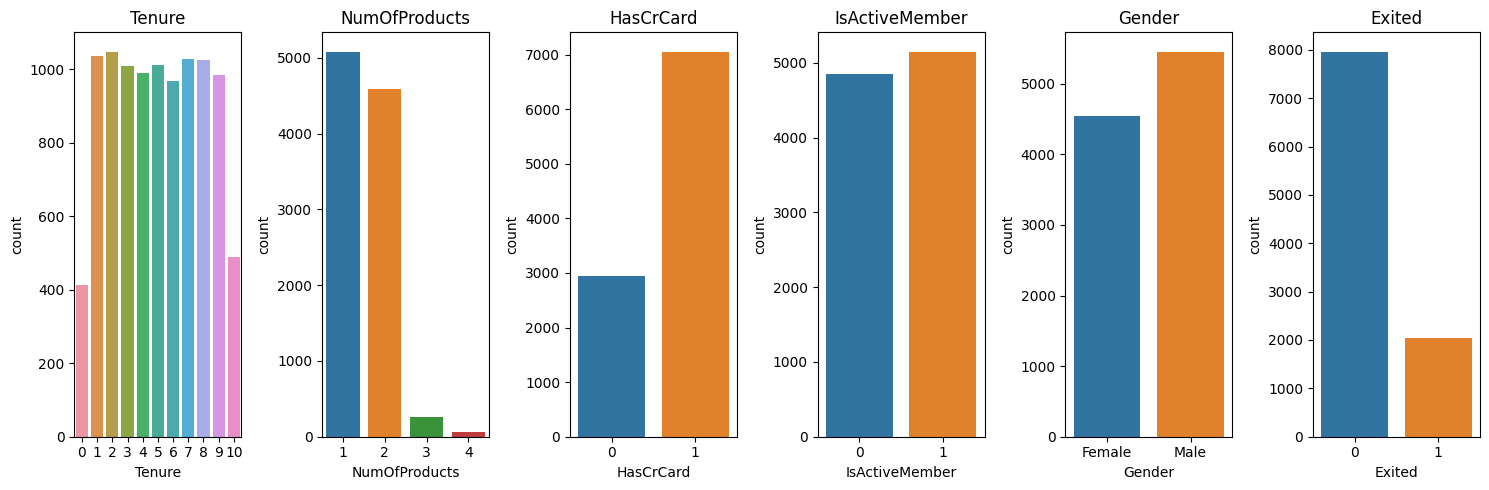

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

sns.countplot(x='Tenure', data=df, ax=axes[0])#, palette='dark')
axes[0].set_title('Tenure')

sns.countplot(x='NumOfProducts', data=df, ax=axes[1])
axes[1].set_title('NumOfProducts')

sns.countplot(x='HasCrCard', data=df, ax=axes[2])
axes[2].set_title('HasCrCard')

sns.countplot(x='IsActiveMember', data=df, ax=axes[3])
axes[3].set_title('IsActiveMember')

sns.countplot(x='Gender', data=df, ax=axes[4])
axes[4].set_title('Gender')

sns.countplot(x='Exited', data=df, ax=axes[5])
axes[5].set_title('Exited')

plt.tight_layout()
plt.show()

Корреляционный и парный анализ

In [19]:
numerical_columns = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary', 'HasCrCard','IsActiveMember','Exited']

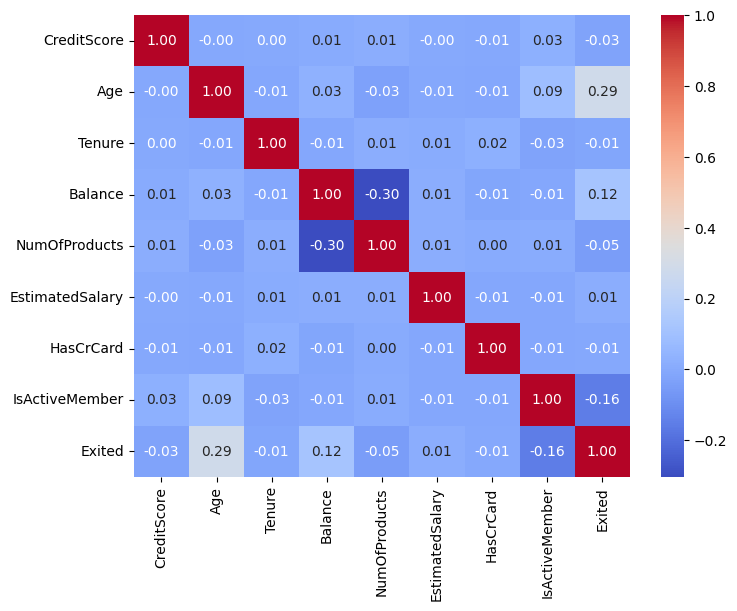

In [20]:
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

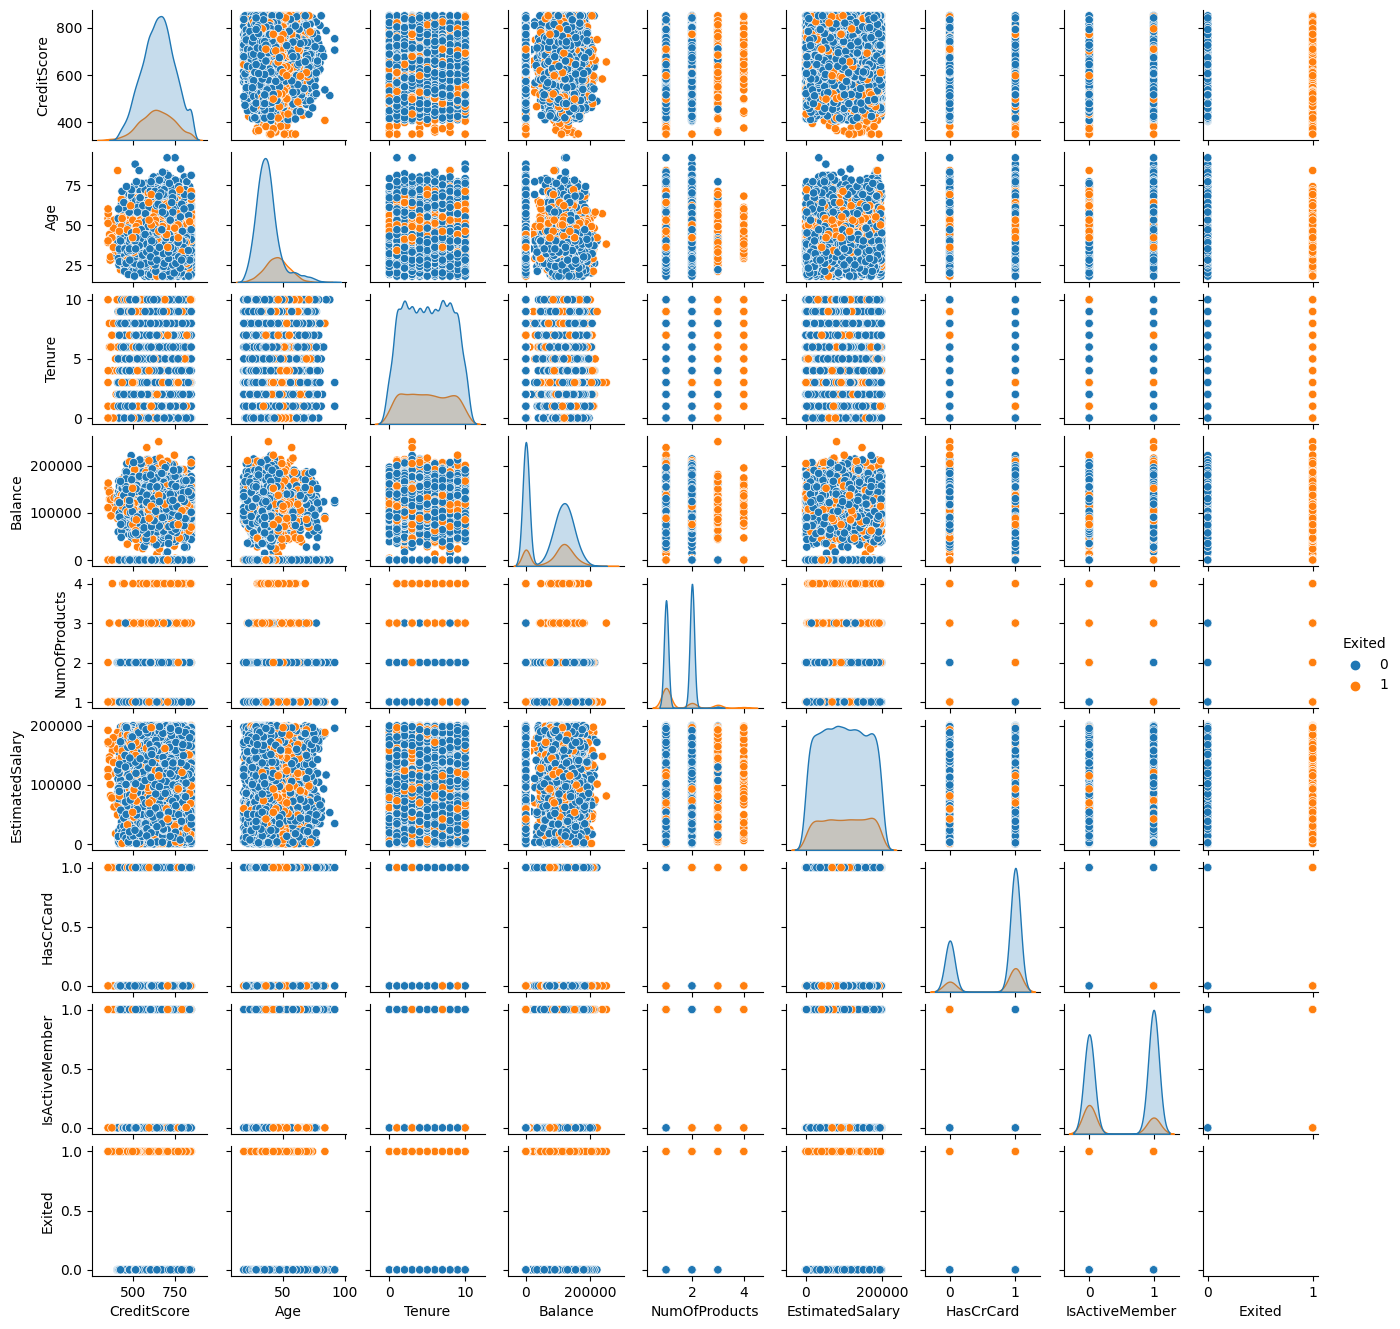

In [21]:
sns.pairplot(df, vars=numerical_columns, hue='Exited', height=1.5, aspect=1)
plt.show()

* видится разделение по возрасту и числу продуктов

In [22]:
age_counts = df.groupby('Age')['Exited'].value_counts().unstack(fill_value=0)

age_counts['difference'] = age_counts[1] - age_counts[0]

positive_difference = age_counts[age_counts['difference'] > 0]

max_positive_difference_age = positive_difference['difference'].idxmax()
max_positive_difference_value = positive_difference['difference'].max()

print(f"Возраст с сымым высоким соотношением ушедших к оставшимся: {max_positive_difference_age} (Разница: {max_positive_difference_value})")

Возраст с сымым высоким соотношением ушедших к оставшимся: 56 (Разница: 30)


# Предобработка

In [23]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [24]:
df_ = df.copy() 

# Создание новых признаков
df_['TargetAge'] = (56 - np.abs(df_['Age'] - 56)) / 56 

# One-Hot кодирование
columns_to_encode = [
    'Geography',
    'Gender',
    'NumOfProducts'
]
encoder = OneHotEncoder(drop='if_binary', sparse=False)
encoded_data = encoder.fit_transform(df_[columns_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode), index=df_.index)
df_ = pd.concat([df_, encoded_df], axis=1)
df_.drop(columns=columns_to_encode, inplace=True)
boolean_cols = df_.select_dtypes(include=bool).columns
df_[boolean_cols] = df_[boolean_cols].astype(int)

# Удаление лишних атрибутов
df_ = df_.drop(columns=[
#     'Age',
#     'Tenure',
    'HasCrCard',
    #'NumOfProducts_4',
    'Geography_Spain',
#      'Geography_France',
])

scaler = MinMaxScaler()

features = df_.columns.drop('Exited')

print(features)

df_[features] = scaler.fit_transform(df_[features])

df_

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember',
       'EstimatedSalary', 'TargetAge', 'Geography_France', 'Geography_Germany',
       'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4'],
      dtype='object')


,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,Exited,TargetAge,Geography_France,Geography_Germany,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
RowNumber,,,,,,,,,,,,,,,
1,0.538,0.324324,0.2,0.000000,1.0,0.506735,1,0.631579,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.516,0.310811,0.1,0.334031,1.0,0.562709,0,0.605263,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.304,0.324324,0.8,0.636357,0.0,0.569654,1,0.631579,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.698,0.283784,0.1,0.000000,0.0,0.469120,0,0.552632,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.000,0.337838,0.2,0.500246,1.0,0.395400,0,0.657895,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.842,0.283784,0.5,0.000000,0.0,0.481341,0,0.552632,1.0,0.0,1.0,0.0,1.0,0.0,0.0
9997,0.332,0.229730,1.0,0.228657,1.0,0.508490,0,0.447368,1.0,0.0,1.0,1.0,0.0,0.0,0.0
9998,0.718,0.243243,0.7,0.000000,1.0,0.210390,1,0.473684,1.0,0.0,0.0,1.0,0.0,0.0,0.0


['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember',
       'EstimatedSalary', 'TargetAge', 'Geography_Germany', 'Geography_France',
       'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4']

In [25]:
features

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember',
       'EstimatedSalary', 'TargetAge', 'Geography_France', 'Geography_Germany',
       'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4'],
      dtype='object')

In [26]:
X = df_[features]
y = df_['Exited']

In [27]:
X.head()

,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,TargetAge,Geography_France,Geography_Germany,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
RowNumber,,,,,,,,,,,,,,
1,0.538,0.324324,0.2,0.000000,1.0,0.506735,0.631579,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.516,0.310811,0.1,0.334031,1.0,0.562709,0.605263,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.304,0.324324,0.8,0.636357,0.0,0.569654,0.631579,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.698,0.283784,0.1,0.000000,0.0,0.469120,0.552632,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.000,0.337838,0.2,0.500246,1.0,0.395400,0.657895,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Первичное сравнение моделей

In [ ]:
def evaluate_model(model, X_test, y_test):
    
    if isinstance(model, keras.Model):
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        prob_val = model.predict(X_test) 
    else:
        y_pred = model.predict(X_test) 
        prob_val = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, prob_val)
    precision, recall, _ = precision_recall_curve(y_test, prob_val)

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].plot(fpr, tpr, linestyle='-', label='ROC кривая')
    ax[0].plot([0, 1], [0, 1], linestyle='--', label='Случайное предсказание')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_xlabel('FP')
    ax[0].set_ylabel('TP')
    ax[0].set_title('ROC Кривая')
    ax[0].legend()

    ax[1].plot(recall, precision, linestyle='-', label='PR Кривая')
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR Кривая')
    ax[1].legend()
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[2], cbar=False)
    ax[2].set_xlabel("Предсказанные")
    ax[2].set_ylabel("Истинные")
    ax[2].set_title("Матрица ошибок")

    plt.tight_layout()
    plt.show()

    metrics_dict = {
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'ROC-AUC': auc(fpr, tpr),
        'PR-AUC': auc(recall, precision),
    }
    
    print(metrics_dict)
    
    return metrics_dict

In [ ]:
results = {}

logit

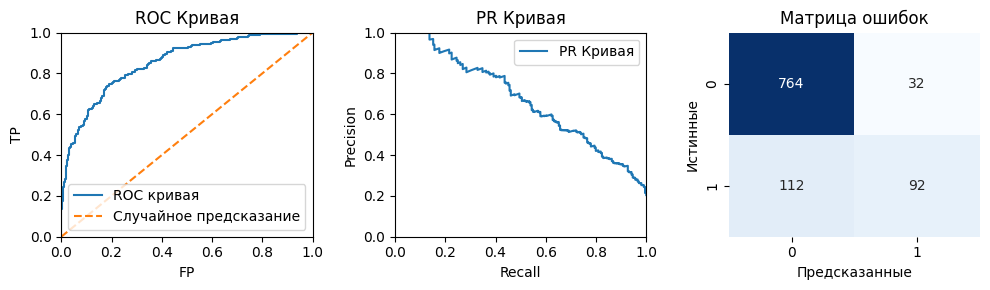

{'Balanced Accuracy': 0.7053896935658686, 'Accuracy': 0.856, 'Recall': 0.45098039215686275, 'Precision': 0.7419354838709677, 'ROC-AUC': 0.8546285348310179, 'PR-AUC': 0.6712440848229526}


In [105]:
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train,y_train)
results['Logistic Regression'] = evaluate_model(logit,X_test,y_test)

с балансировкой классов

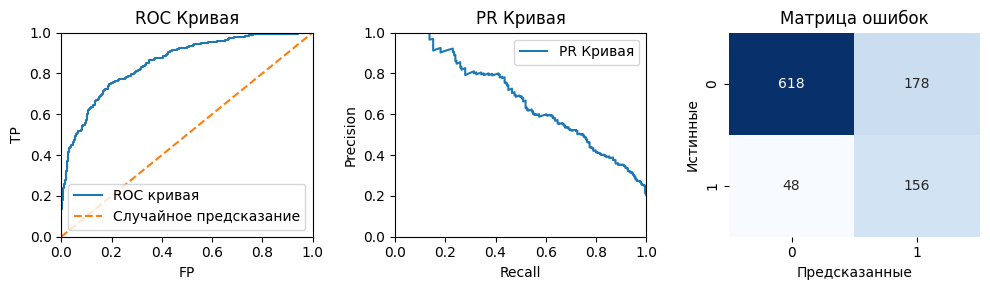

{'Balanced Accuracy': 0.7705438959503399, 'Accuracy': 0.774, 'Recall': 0.7647058823529411, 'Precision': 0.46706586826347307, 'ROC-AUC': 0.8554722140112325, 'PR-AUC': 0.6701158822027335}


In [106]:
logit = LogisticRegression(max_iter=1000, class_weight='balanced')
logit.fit(X_train,y_train)
_ = evaluate_model(logit,X_test,y_test)

random forest

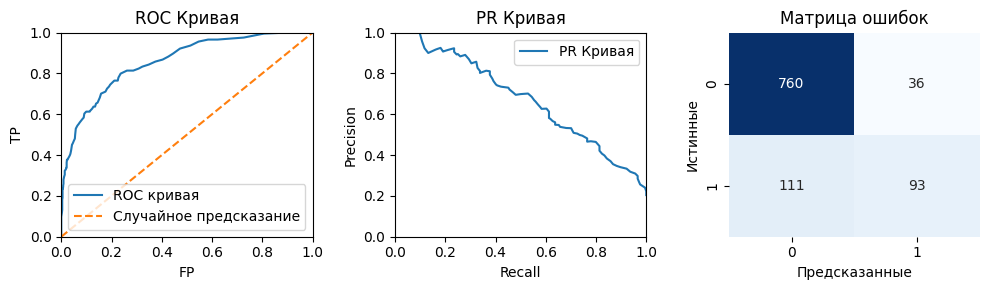

{'Balanced Accuracy': 0.7053281111439551, 'Accuracy': 0.853, 'Recall': 0.45588235294117646, 'Precision': 0.7209302325581395, 'ROC-AUC': 0.8570394866489309, 'PR-AUC': 0.6748363079069791}


In [107]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
results['Random Forest'] = evaluate_model(rf,X_test,y_test)

xgboost

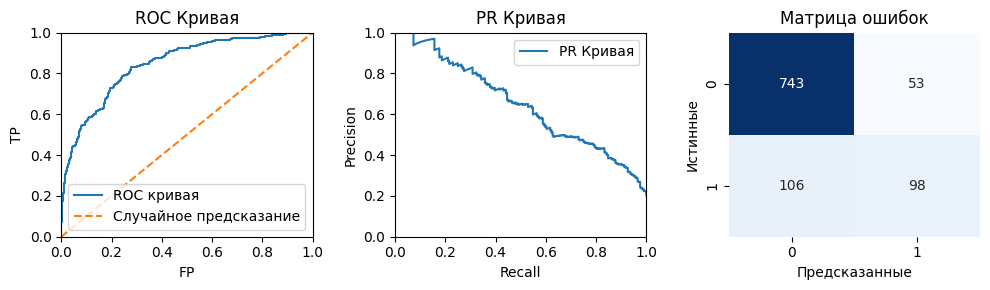

{'Balanced Accuracy': 0.7069046211449403, 'Accuracy': 0.841, 'Recall': 0.4803921568627451, 'Precision': 0.6490066225165563, 'ROC-AUC': 0.8482485959207805, 'PR-AUC': 0.6488639930089488}


In [108]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)
results['XGBoost'] = evaluate_model(xgb,X_test,y_test)

lightgbm

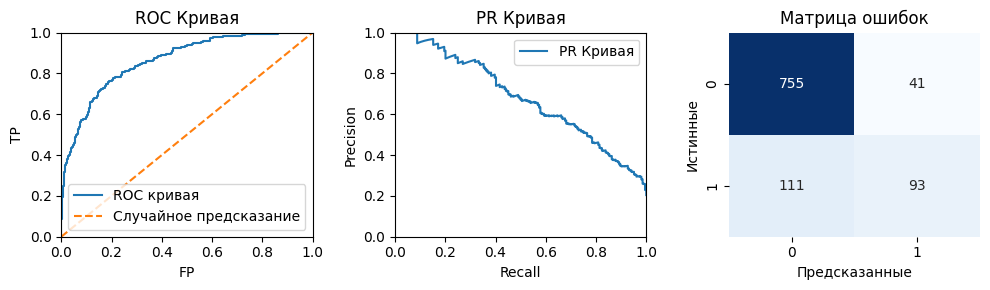

{'Balanced Accuracy': 0.7021874076263671, 'Accuracy': 0.848, 'Recall': 0.45588235294117646, 'Precision': 0.6940298507462687, 'ROC-AUC': 0.8653500344861563, 'PR-AUC': 0.6803770867065464}


In [109]:
lgbm = lgb.LGBMClassifier(verbosity=-1)
lgbm.fit(X_train,y_train)
results['LightGBM'] = evaluate_model(lgbm,X_test,y_test)

catboost

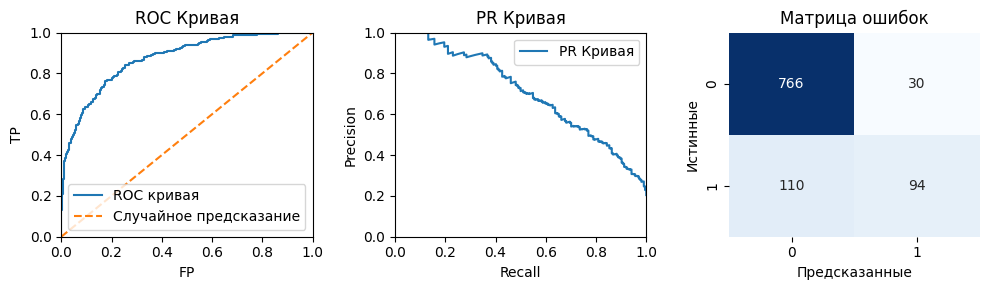

{'Balanced Accuracy': 0.7115479357572174, 'Accuracy': 0.86, 'Recall': 0.46078431372549017, 'Precision': 0.7580645161290323, 'ROC-AUC': 0.8739962065228101, 'PR-AUC': 0.7077172687731097}


In [110]:
cb = catboost.CatBoostClassifier(silent=True)
cb.fit(X_train,y_train)
results['CatBoost'] = evaluate_model(cb,X_test,y_test)

NN

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_199 (Dense)               │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,345 (36.50 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Accuracy: 0.7990 - loss: 0.5055 - val_Accuracy: 0.8470 - val_loss: 0.3742
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Accuracy: 0.8318 - loss: 0.3949 - val_Accuracy: 0.8550 - val_loss: 0.3575
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Accuracy: 0.8449 - loss: 0.3791 - val_Accuracy: 0.8620 - val_loss: 0.3480
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.8550 - loss: 0.3661 - val_Accuracy: 0.8510 - val_loss: 0.3567
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Accuracy: 0.8506 - loss: 0.3664 - val_Accuracy: 0.8600 - val_loss: 0.3446
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.8492 - loss: 0.3661 - val_Accuracy: 0.8570 - val_loss: 0.3435
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Accuracy: 0.8463 - loss: 0.3744 - val_Accuracy: 0.8580 - val_loss: 0.3448
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Accuracy: 0.8639 - loss: 0.3381 - val_Accu

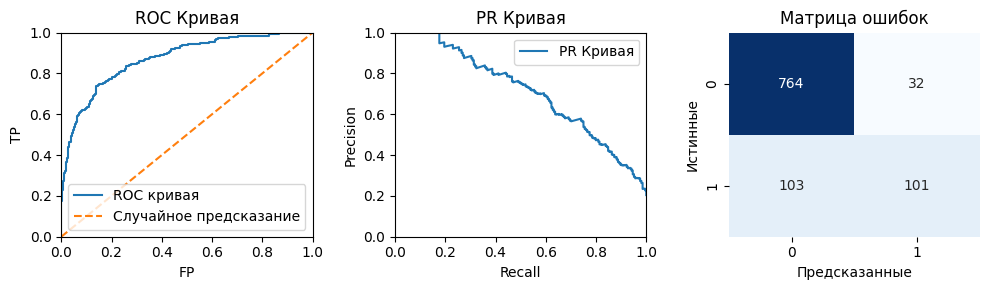

{'Balanced Accuracy': 0.7274485170952804, 'Accuracy': 0.865, 'Recall': 0.4950980392156863, 'Precision': 0.7593984962406015, 'ROC-AUC': 0.8731402108582126, 'PR-AUC': 0.7109172091816359}


In [111]:
nn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['Accuracy']
)

nn.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

results['NN'] = evaluate_model(nn,X_test,y_test)

cnn

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_29 (Conv1D)              │ (None, 13, 128)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 12, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 11, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,617 (170.38 KB)

 Trainable params: 43,617 (170.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - Accuracy: 0.7919 - loss: 0.4912 - val_Accuracy: 0.8570 - val_loss: 0.3537
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - Accuracy: 0.8468 - loss: 0.3873 - val_Accuracy: 0.8540 - val_loss: 0.3502
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Accuracy: 0.8510 - loss: 0.3669 - val_Accuracy: 0.8440 - val_loss: 0.3556
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.8531 - loss: 0.3514 - val_Accuracy: 0.8570 - val_loss: 0.3445
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Accuracy: 0.8587 - loss: 0.3559 - val_Accuracy: 0.8500 - val_loss: 0.3473
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Accuracy: 0.8560 - loss: 0.3577 - val_Accuracy: 0.8520 - val_loss: 0.3522
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Accuracy: 0.8585 - loss: 0.3491 - val_Accuracy: 0.8540 - val_loss: 0.3430
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Accuracy: 0.8556 - loss: 0.3562 - val_A

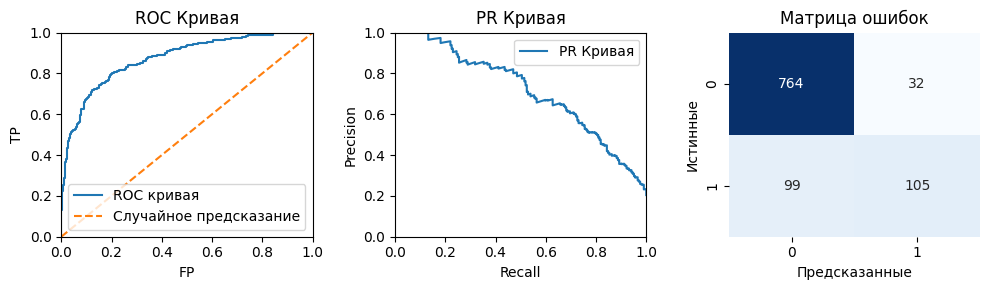

{'Balanced Accuracy': 0.7372524386639078, 'Accuracy': 0.869, 'Recall': 0.5147058823529411, 'Precision': 0.7664233576642335, 'ROC-AUC': 0.8750677406641049, 'PR-AUC': 0.7151285432687898}
CPU times: user 1min 11s, sys: 1.23 s, total: 1min 12s
Wall time: 2min 12s


In [112]:
%%time 

cnn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.Conv1D(128, kernel_size=2, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(64, kernel_size=2, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(32, kernel_size=2, activation='relu'),
    layers.Dropout(0.1),
    #layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), 
    #layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['Accuracy']
)

cnn.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

history = cnn.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

results['CNN'] = evaluate_model(cnn, X_test, y_test)


In [113]:
pd.DataFrame.from_dict(results, orient='index')

,Balanced Accuracy,Accuracy,Recall,Precision,ROC-AUC,PR-AUC
Logistic Regression,0.705390,0.856,0.450980,0.741935,0.854629,0.671244
Random Forest,0.705328,0.853,0.455882,0.720930,0.857039,0.674836
XGBoost,0.706905,0.841,0.480392,0.649007,0.848249,0.648864
LightGBM,0.702187,0.848,0.455882,0.694030,0.865350,0.680377
CatBoost,0.711548,0.860,0.460784,0.758065,0.873996,0.707717
NN,0.727449,0.865,0.495098,0.759398,0.873140,0.710917
CNN,0.737252,0.869,0.514706,0.766423,0.875068,0.715129


# Сравнение техник ресемплинга

In [114]:
results = {}

# Оригинальный набор

In [115]:
print("Class distribution before:")
print(pd.Series(y_train).value_counts(normalize=True))

X_train.shape

Class distribution before:
Exited
0    0.796333
1    0.203667
Name: proportion, dtype: float64


(9000, 14)

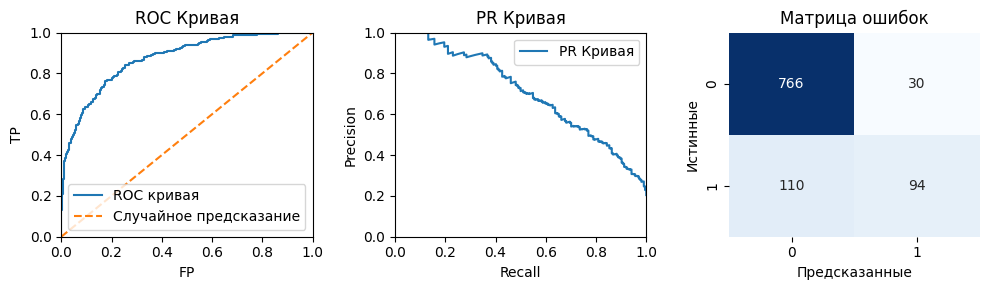

{'Balanced Accuracy': 0.7115479357572174, 'Accuracy': 0.86, 'Recall': 0.46078431372549017, 'Precision': 0.7580645161290323, 'ROC-AUC': 0.8739962065228101, 'PR-AUC': 0.7077172687731097}


In [116]:
cb = catboost.CatBoostClassifier(silent=True)
cb.fit(X_train,y_train)
results['None'] = evaluate_model(cb,X_test,y_test)

# ROS

In [117]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print("Распределение классов после ROS:")
print(pd.Series(y_ros).value_counts(normalize=True))

X_ros.shape

Распределение классов после ROS:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


(14334, 14)

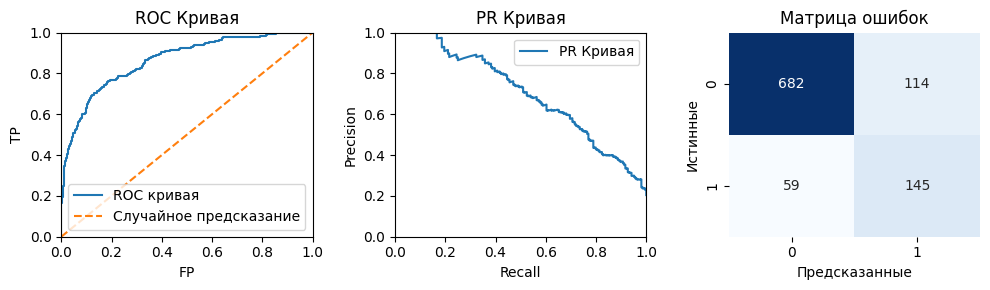

{'Balanced Accuracy': 0.7837841166617401, 'Accuracy': 0.827, 'Recall': 0.7107843137254902, 'Precision': 0.5598455598455598, 'ROC-AUC': 0.8661506059710316, 'PR-AUC': 0.7009676900979197}


In [118]:
cb.fit(X_ros,y_ros)
results['ROS'] = evaluate_model(cb,X_test,y_test)

# SMOTE

In [119]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Распределение классов после SMOTE:")
print(pd.Series(y_smote).value_counts(normalize=True))

X_smote.shape

Распределение классов после SMOTE:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


(14334, 14)

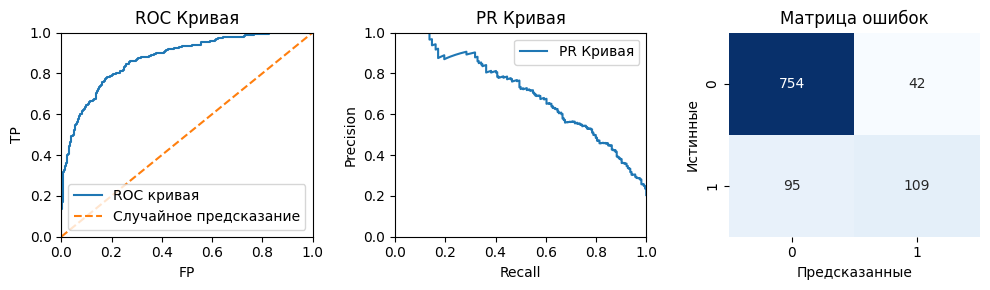

{'Balanced Accuracy': 0.7407749531973593, 'Accuracy': 0.863, 'Recall': 0.5343137254901961, 'Precision': 0.7218543046357616, 'ROC-AUC': 0.8758375209380234, 'PR-AUC': 0.7056306617429567}


In [120]:
cb.fit(X_smote,y_smote)
results['SMOTE'] = evaluate_model(cb,X_test,y_test)

# ADASYN

In [121]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

print("Распределение классов после ADASYN:")
print(pd.Series(y_adasyn).value_counts(normalize=True))

X_adasyn.shape

Распределение классов после ADASYN:
Exited
0    0.515612
1    0.484388
Name: proportion, dtype: float64


(13900, 14)

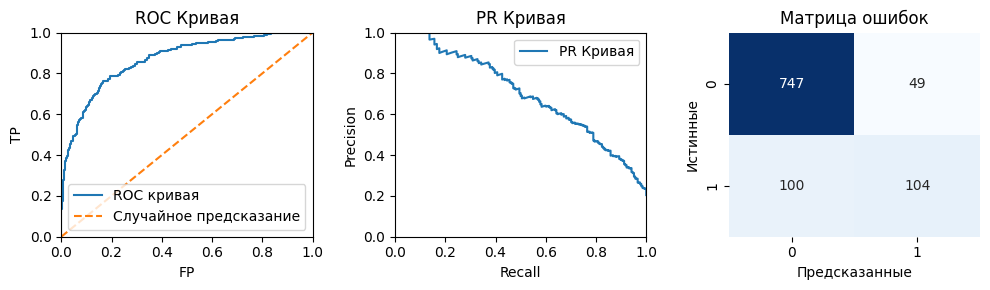

{'Balanced Accuracy': 0.7241230663119519, 'Accuracy': 0.851, 'Recall': 0.5098039215686274, 'Precision': 0.6797385620915033, 'ROC-AUC': 0.8702396787860873, 'PR-AUC': 0.699572017531981}


In [122]:
cb.fit(X_adasyn,y_adasyn)
results['ADASYN'] = evaluate_model(cb,X_test,y_test)

# Random Under Sampling

In [123]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Распределение классов после RUS:")
print(pd.Series(y_rus).value_counts(normalize=True))

X_rus.shape

Распределение классов после RUS:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


(3666, 14)

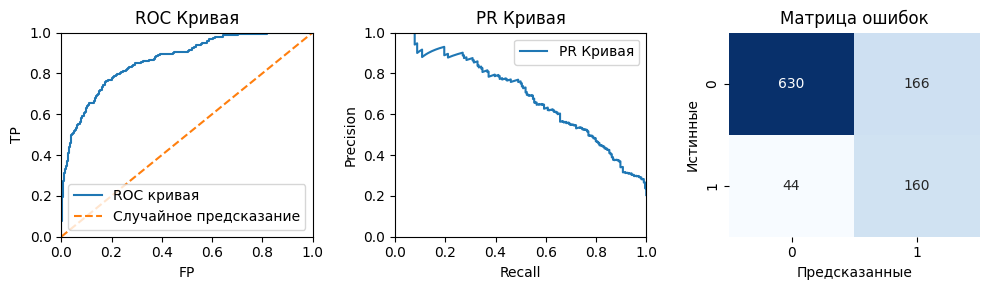

{'Balanced Accuracy': 0.7878855059611785, 'Accuracy': 0.79, 'Recall': 0.7843137254901961, 'Precision': 0.49079754601226994, 'ROC-AUC': 0.8681766676519854, 'PR-AUC': 0.6878354563991881}


In [124]:
cb.fit(X_rus,y_rus)
results['RUS'] = evaluate_model(cb,X_test,y_test)

# NearMiss

Распределение классов после NearMiss:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64
(3666, 14)


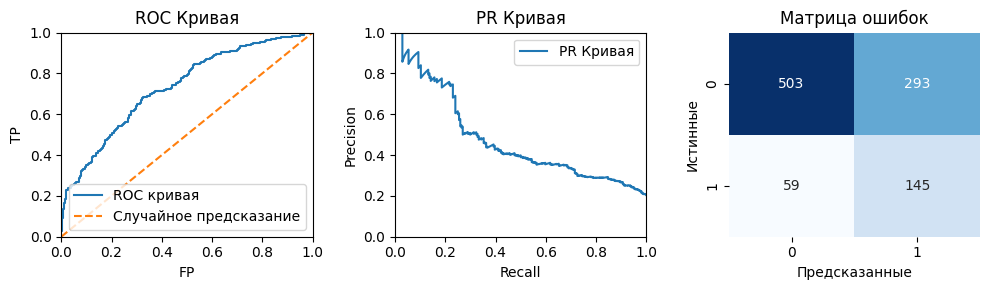

{'Balanced Accuracy': 0.6713469307320918, 'Accuracy': 0.648, 'Recall': 0.7107843137254902, 'Precision': 0.3310502283105023, 'ROC-AUC': 0.7333419548724013, 'PR-AUC': 0.47348732102700364}


In [125]:
nm = NearMiss(version=1)
X_nearmiss, y_nearmiss = nm.fit_resample(X_train, y_train)

print("Распределение классов после NearMiss:")
print(pd.Series(y_nearmiss).value_counts(normalize=True))
print(X_nearmiss.shape)

cb.fit(X_nearmiss,y_nearmiss)
results['NearMiss-1'] = evaluate_model(cb,X_test,y_test)

Распределение классов после NearMiss:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64
(3666, 14)


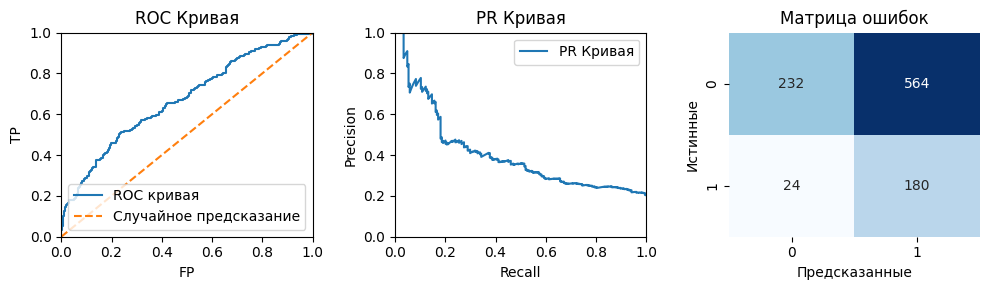

{'Balanced Accuracy': 0.5869051138043156, 'Accuracy': 0.412, 'Recall': 0.8823529411764706, 'Precision': 0.24193548387096775, 'ROC-AUC': 0.6717102670213815, 'PR-AUC': 0.40348671529918584}


In [126]:
nm = NearMiss(version=2)
X_nearmiss, y_nearmiss = nm.fit_resample(X_train, y_train)

print("Распределение классов после NearMiss:")
print(pd.Series(y_nearmiss).value_counts(normalize=True))
print(X_nearmiss.shape)

cb.fit(X_nearmiss,y_nearmiss)
results['NearMiss-2'] = evaluate_model(cb,X_test,y_test)

Распределение классов после NearMiss:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64
(3666, 14)


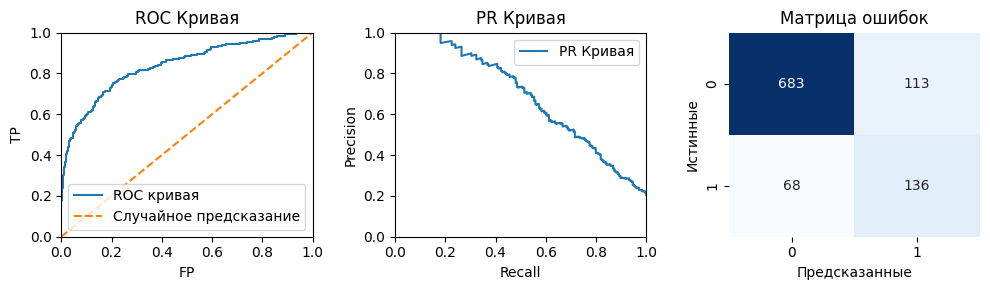

{'Balanced Accuracy': 0.7623534338358459, 'Accuracy': 0.819, 'Recall': 0.6666666666666666, 'Precision': 0.5461847389558233, 'ROC-AUC': 0.8403229382205144, 'PR-AUC': 0.6881605178631581}


In [127]:
nm = NearMiss(version=3)
X_nearmiss, y_nearmiss = nm.fit_resample(X_train, y_train)

print("Распределение классов после NearMiss:")
print(pd.Series(y_nearmiss).value_counts(normalize=True))
print(X_nearmiss.shape)

cb.fit(X_nearmiss,y_nearmiss)
results['NearMiss-3'] = evaluate_model(cb,X_test,y_test)

сравнение метрик

In [128]:
pd.DataFrame.from_dict(results, orient='index')

,Balanced Accuracy,Accuracy,Recall,Precision,ROC-AUC,PR-AUC
None,0.711548,0.860,0.460784,0.758065,0.873996,0.707717
ROS,0.783784,0.827,0.710784,0.559846,0.866151,0.700968
SMOTE,0.740775,0.863,0.534314,0.721854,0.875838,0.705631
ADASYN,0.724123,0.851,0.509804,0.679739,0.870240,0.699572
RUS,0.787886,0.790,0.784314,0.490798,0.868177,0.687835
NearMiss-1,0.671347,0.648,0.710784,0.331050,0.733342,0.473487
NearMiss-2,0.586905,0.412,0.882353,0.241935,0.671710,0.403487
NearMiss-3,0.762353,0.819,0.666667,0.546185,0.840323,0.688161


RUS лучший Balanced Accuracy

In [129]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Распределение классов после RUS:")
print(pd.Series(y_rus).value_counts(normalize=True))

X_rus.shape

cb = catboost.CatBoostClassifier(silent=True)
cb.fit(X_rus,y_rus)

y_pred = cb.predict(X_test)

balanced_accuracy_score(y_test,y_pred)

Распределение классов после RUS:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


0.7878855059611785

In [130]:
X_train, y_train = X_rus, y_rus

# Обучение моделей

In [131]:
results = {}

# Optuna

# Логистическая регрессия

In [132]:
%%time

def objective(trial):
    params = {
        'tol': trial.suggest_float('tol', 1e-6, 1e-3, step=1e-6),
        'C': trial.suggest_float('C', 1e-3, 1,step=1e-3),
        #'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        #'penalty': trial.suggest_categorical('penalty', ['l2', None]),
        'max_iter': trial.suggest_int('max_iter', 150, 1000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = LogisticRegression(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:05:55,776] A new study created in memory with name: no-name-f1f014cc-11d0-4567-af65-d200a292618b
[I 2024-05-18 07:05:55,953] Trial 0 finished with value: 0.7655187703221993 and parameters: {'tol': 0.00052, 'C': 1.0, 'max_iter': 314, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7655187703221993.
[I 2024-05-18 07:05:56,109] Trial 1 finished with value: 0.7648906296186816 and parameters: {'tol': 3.5e-05, 'C': 0.587, 'max_iter': 262, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7655187703221993.
[I 2024-05-18 07:05:56,233] Trial 2 finished with value: 0.7617499261010936 and parameters: {'tol': 0.00010999999999999999, 'C': 0.245, 'max_iter': 923, 'class_weight': None}. Best is trial 0 with value: 0.7655187703221993.
[I 2024-05-18 07:05:56,386] Trial 3 finished with value: 0.7655187703221993 and parameters: {'tol': 5.999999999999999e-06, 'C': 0.683, 'max_iter': 840, 'class_weight': None}. Best is trial 0 with value: 0.7655187703221993.
[I 2024-05-

Best hyperparameters: {'tol': 0.000695, 'C': 0.742, 'max_iter': 582, 'class_weight': None}
Best score: 0.7661469110257169
CPU times: user 3.92 s, sys: 3.17 s, total: 7.09 s
Wall time: 7.05 s


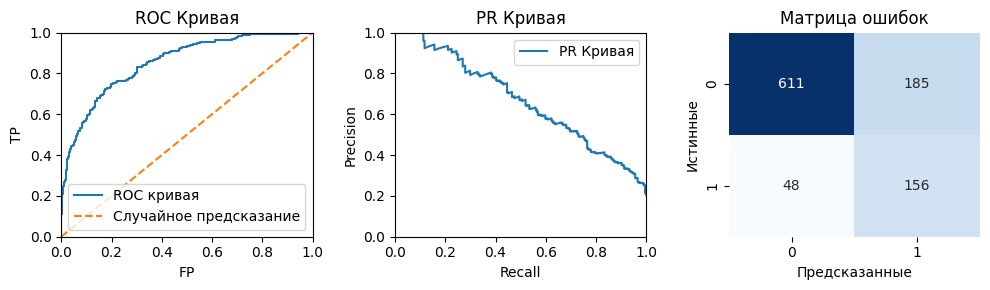

{'Balanced Accuracy': 0.7661469110257169, 'Accuracy': 0.767, 'Recall': 0.7647058823529411, 'Precision': 0.4574780058651026, 'ROC-AUC': 0.8549364469405853, 'PR-AUC': 0.6671659728831312}


In [133]:
#best_params = {'tol': 0.000882, 'C': 0.876, 'max_iter': 397}
logit = LogisticRegression(**best_params)
logit.fit(X_train,y_train)
results['Logistic Regression'] = evaluate_model(logit,X_test,y_test)


# Random Forest

In [134]:
%%time

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42
    }
        
    model = RandomForestClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc

tpe_sampler = optuna.samplers.TPESampler()

study = optuna.create_study(direction='maximize', sampler=tpe_sampler)

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:06:04,053] A new study created in memory with name: no-name-ac582550-1bb6-4d7a-89ae-258542b9639a
[I 2024-05-18 07:06:04,937] Trial 0 finished with value: 0.7746822347029264 and parameters: {'n_estimators': 212, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7746822347029264.
[I 2024-05-18 07:06:06,820] Trial 1 finished with value: 0.7792147009557592 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7792147009557592.
[I 2024-05-18 07:06:09,252] Trial 2 finished with value: 0.7734259532958913 and parameters: {'n_estimators': 582, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'log_lo

Best hyperparameters: {'n_estimators': 749, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None}
Best score: 0.7923440733077151
CPU times: user 1min 43s, sys: 400 ms, total: 1min 43s
Wall time: 1min 43s


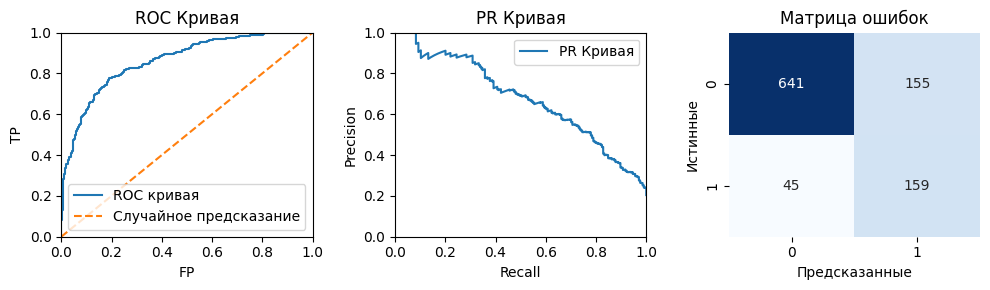

{'Balanced Accuracy': 0.7923440733077151, 'Accuracy': 0.8, 'Recall': 0.7794117647058824, 'Precision': 0.5063694267515924, 'ROC-AUC': 0.863545669524091, 'PR-AUC': 0.6769966314807209}


In [135]:
#best_params = {'n_estimators': 342, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
rf = RandomForestClassifier(**best_params, random_state=42)
rf.fit(X_train,y_train)
results['Random Forest'] = evaluate_model(rf,X_test,y_test)

# CatBoost

In [136]:
%%time

def objective(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 20.0, step=0.001),
        'random_strength': trial.suggest_float('random_strength', 0.001, 10, step=0.001),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1, step=0.001),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'verbose' : 0
    }

        
    model = catboost.CatBoostClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc

tpe_sampler = optuna.samplers.TPESampler()

study = optuna.create_study(direction='maximize', sampler=tpe_sampler)

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:07:52,553] A new study created in memory with name: no-name-18d57cd0-8f03-4011-929c-a5b1bff8d25f
[I 2024-05-18 07:07:56,473] Trial 0 finished with value: 0.801519854172825 and parameters: {'iterations': 481, 'learning_rate': 0.032, 'depth': 6, 'l2_leaf_reg': 2.561, 'random_strength': 7.336, 'bagging_temperature': 0.053, 'border_count': 243, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.801519854172825.
[I 2024-05-18 07:07:57,941] Trial 1 finished with value: 0.7822938220514337 and parameters: {'iterations': 200, 'learning_rate': 0.007, 'depth': 11, 'l2_leaf_reg': 14.232000000000001, 'random_strength': 4.5200000000000005, 'bagging_temperature': 0.896, 'border_count': 73, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.801519854172825.
[I 2024-05-18 07:08:02,261] Trial 2 finished with value: 0.7843014090058134 and parameters: {'iterations': 211, 'learning_rate': 0.051000000000000004, 'depth': 9, 'l2_leaf_reg': 5.029, 'random_strength': 6.69300000000

Best hyperparameters: {'iterations': 787, 'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 17.619, 'random_strength': 1.755, 'bagging_temperature': 0.183, 'border_count': 209, 'boosting_type': 'Plain'}
Best score: 0.8095009360528131
CPU times: user 4min 53s, sys: 38.9 s, total: 5min 32s
Wall time: 1min 39s


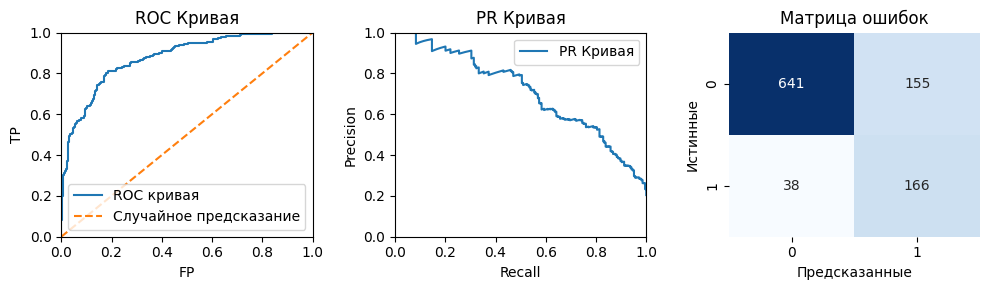

{'Balanced Accuracy': 0.8095009360528131, 'Accuracy': 0.807, 'Recall': 0.8137254901960784, 'Precision': 0.5171339563862928, 'ROC-AUC': 0.8784917233224948, 'PR-AUC': 0.7077992517717805}


In [137]:
#best_params = {'iterations': 382, 'learning_rate': 0.021, 'depth': 6, 'l2_leaf_reg': 18.565, 'random_strength': 0.21, 'bagging_temperature': 0.288, 'border_count': 42, 'boosting_type': 'Ordered'}
cb = catboost.CatBoostClassifier(
    **best_params, 
    verbose=0
)
cb.fit(X_train,y_train)
results['CatBoost'] = evaluate_model(cb,X_test,y_test)


# XGBoost

In [138]:
%%time

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 20.0, step=0.001),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0, step=0.001),
        'subsample': trial.suggest_float('subsample', 0.1, 1, step=0.001),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1, step=0.001),
        'gamma': trial.suggest_float('gamma', 0, 10, step=0.001),
        'verbosity': 0,
    }
        
    model = xgboost.XGBClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc

tpe_sampler = optuna.samplers.TPESampler()

study = optuna.create_study(direction='maximize', sampler=tpe_sampler)

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:09:34,034] A new study created in memory with name: no-name-52e2664b-b451-4ee2-a286-731cbebe6ff0
[I 2024-05-18 07:09:35,442] Trial 0 finished with value: 0.7642009064932506 and parameters: {'n_estimators': 1059, 'learning_rate': 0.092, 'max_depth': 199, 'reg_lambda': 13.293000000000001, 'reg_alpha': 0.808, 'subsample': 0.721, 'colsample_bytree': 0.397, 'gamma': 0.274}. Best is trial 0 with value: 0.7642009064932506.
[I 2024-05-18 07:09:35,691] Trial 1 finished with value: 0.7866908069760568 and parameters: {'n_estimators': 348, 'learning_rate': 0.066, 'max_depth': 148, 'reg_lambda': 18.008, 'reg_alpha': 0.181, 'subsample': 0.784, 'colsample_bytree': 0.29500000000000004, 'gamma': 6.923}. Best is trial 1 with value: 0.7866908069760568.
[I 2024-05-18 07:09:36,846] Trial 2 finished with value: 0.7729948763424968 and parameters: {'n_estimators': 2048, 'learning_rate': 0.034, 'max_depth': 131, 'reg_lambda': 16.219, 'reg_alpha': 0.612, 'subsample': 0.273, 'colsample_bytree': 

Best hyperparameters: {'n_estimators': 2219, 'learning_rate': 0.023, 'max_depth': 141, 'reg_lambda': 6.996, 'reg_alpha': 0.643, 'subsample': 0.879, 'colsample_bytree': 0.636, 'gamma': 2.914}
Best score: 0.8033426938614642
CPU times: user 42 s, sys: 923 ms, total: 42.9 s
Wall time: 42.9 s


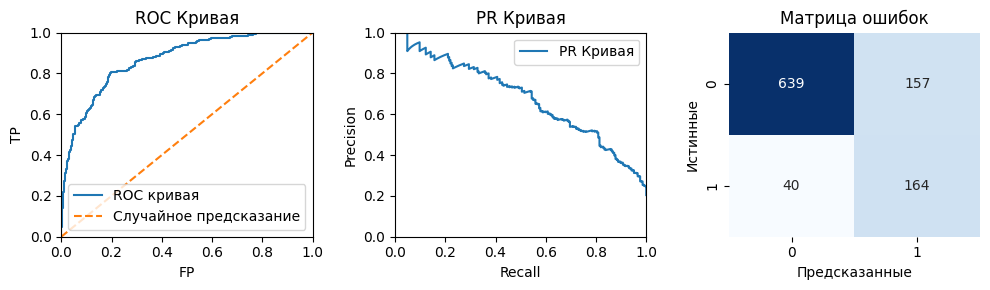

{'Balanced Accuracy': 0.8033426938614642, 'Accuracy': 0.803, 'Recall': 0.803921568627451, 'Precision': 0.5109034267912772, 'ROC-AUC': 0.870516799684698, 'PR-AUC': 0.6767075971241051}


In [139]:
#best_params = {'n_estimators': 2015, 'learning_rate': 0.043, 'max_depth': 185, 'reg_lambda': 11.982, 'reg_alpha': 0.702, 'subsample': 0.895, 'colsample_bytree': 0.704, 'gamma': 2.439}
xgb = xgboost.XGBClassifier(**best_params)
xgb.fit(X_train,y_train)
results['XGBoost'] = evaluate_model(xgb,X_test,y_test)

# LightGBM

In [140]:
%%time

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, step=0.001), 
        'max_depth': trial.suggest_int('max_depth', 5, 200),  
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),  
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0, step=0.001),  
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0, step=0.001), 
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),  
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10, step=0.001), 
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0, step=0.001), 
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0, step=0.001),  
        'verbosity': -1,  
    }
    
    model = lgb.LGBMClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc

tpe_sampler = optuna.samplers.TPESampler()

study = optuna.create_study(direction='maximize', sampler=tpe_sampler)

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:10:19,374] A new study created in memory with name: no-name-7ccea6ba-c34d-4300-b1bf-af4edb2f9b3e
[I 2024-05-18 07:10:22,127] Trial 0 finished with value: 0.7628830426643018 and parameters: {'num_leaves': 189, 'learning_rate': 0.089, 'max_depth': 50, 'n_estimators': 3928, 'feature_fraction': 0.585, 'bagging_fraction': 0.917, 'bagging_freq': 4, 'min_child_weight': 2.229, 'lambda_l1': 3.326, 'lambda_l2': 5.234}. Best is trial 0 with value: 0.7628830426643018.
[I 2024-05-18 07:10:23,489] Trial 1 finished with value: 0.7964331461227707 and parameters: {'num_leaves': 155, 'learning_rate': 0.030000000000000002, 'max_depth': 193, 'n_estimators': 3552, 'feature_fraction': 0.557, 'bagging_fraction': 0.25, 'bagging_freq': 0, 'min_child_weight': 1.783, 'lambda_l1': 7.277, 'lambda_l2': 8.386000000000001}. Best is trial 1 with value: 0.7964331461227707.
[I 2024-05-18 07:10:24,821] Trial 2 finished with value: 0.7858163365848853 and parameters: {'num_leaves': 238, 'learning_rate': 0.

Best hyperparameters: {'num_leaves': 122, 'learning_rate': 0.022000000000000002, 'max_depth': 53, 'n_estimators': 3028, 'feature_fraction': 0.384, 'bagging_fraction': 0.627, 'bagging_freq': 3, 'min_child_weight': 4.275, 'lambda_l1': 9.082, 'lambda_l2': 9.363}
Best score: 0.7969997044043748
CPU times: user 1min 10s, sys: 113 ms, total: 1min 10s
Wall time: 1min 10s


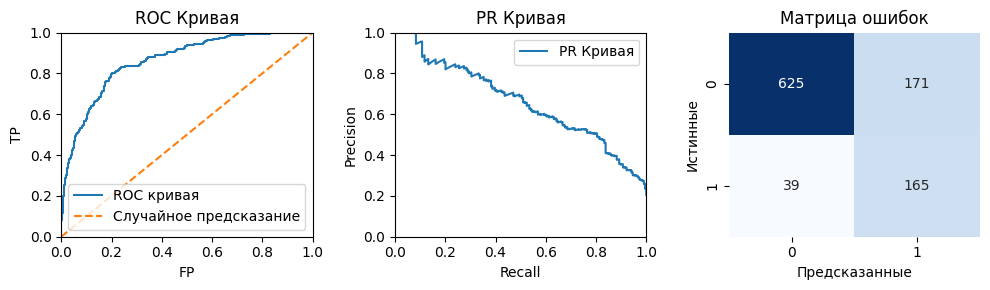

{'Balanced Accuracy': 0.7969997044043748, 'Accuracy': 0.79, 'Recall': 0.8088235294117647, 'Precision': 0.49107142857142855, 'ROC-AUC': 0.8645679377278549, 'PR-AUC': 0.6602388513373418}


In [141]:
#best_params = {'num_leaves': 221, 'learning_rate': 0.021, 'max_depth': 108, 'n_estimators': 4209, 'feature_fraction': 0.502, 'bagging_fraction': 0.129, 'bagging_freq': 0, 'min_child_weight': 2.247, 'lambda_l1': 7.117, 'lambda_l2': 8.14}
lgbm = lgb.LGBMClassifier(**best_params, verbosity=-1)
lgbm.fit(X_train,y_train)
results['LGBM'] = evaluate_model(lgbm,X_test,y_test)

# Полносвязная нейронная сеть

In [142]:
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == "Adam":
        return keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        return keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "SGD":
        return keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unknown optimizer")

In [143]:
%%time

def objective(trial):
    n_layers = trial.suggest_int("n_layers", 2, 8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.001)
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "tanh"])
    units_per_layer = trial.suggest_int("units_per_layer", 16, 256)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, step=0.001)
    l2_reg = trial.suggest_float("l2_reg", 0.001, 0.01, step=0.001)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    epochs = trial.suggest_int("epochs", 10, 100)

    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for _ in range(n_layers):
        model.add(
            layers.Dense(
                units_per_layer,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_reg),
            )
        )
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(1, activation="sigmoid"))

    if optimizer_name == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy"
    )

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        verbose=0,
        validation_data=(X_test, y_test),
        #callbacks=[early_stop]
    )

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    return bal_acc

tpe_sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe_sampler)

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", best_score)


[I 2024-05-18 07:11:33,459] A new study created in memory with name: no-name-10bf677c-5957-4d90-8c72-3a03fb76b0c4


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-05-18 07:12:23,549] Trial 0 finished with value: 0.7602842644595527 and parameters: {'n_layers': 7, 'dropout_rate': 0.43, 'activation': 'relu', 'units_per_layer': 59, 'learning_rate': 0.01, 'l2_reg': 0.007, 'optimizer': 'RMSprop', 'epochs': 70}. Best is trial 0 with value: 0.7602842644595527.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2024-05-18 07:12:53,861] Trial 1 finished with value: 0.7581288796925805 and parameters: {'n_layers': 7, 'dropout_rate': 0.381, 'activation': 'tanh', 'units_per_layer': 241, 'learning_rate': 0.01, 'l2_reg': 0.007, 'optimizer': 'Adam', 'epochs': 18}. Best is trial 0 with value: 0.7602842644595527.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-05-18 07:13:50,974] Trial 2 finished with value: 0.7637698295398562 and parameters: {'n_layers': 8, 'dropout_rate': 0.009000000000000001, 'activation': 'tanh', 'units_per_layer': 121, 'learning_rate': 0.008, 'l2_reg': 0.008, 'optimizer': 'SGD', 'epochs': 81}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:14:11,398] Trial 3 finished with value: 0.759409794068381 and parameters: {'n_layers': 4, 'dropout_rate': 0.209, 'activation': 'relu', 'units_per_layer': 198, 'learning_rate': 0.009000000000000001, 'l2_reg': 0.007, 'optimizer': 'SGD', 'epochs': 26}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-05-18 07:14:29,663] Trial 4 finished with value: 0.6700906493250567 and parameters: {'n_layers': 7, 'dropout_rate': 0.336, 'activation': 'relu', 'units_per_layer': 179, 'learning_rate': 0.009000000000000001, 'l2_reg': 0.006, 'optimizer': 'Adam', 'epochs': 15}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:14:54,937] Trial 5 finished with value: 0.7163267316977042 and parameters: {'n_layers': 2, 'dropout_rate': 0.134, 'activation': 'sigmoid', 'units_per_layer': 134, 'learning_rate': 0.006, 'l2_reg': 0.009000000000000001, 'optimizer': 'Adam', 'epochs': 73}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2024-05-18 07:16:39,934] Trial 6 finished with value: 0.7355034978815647 and parameters: {'n_layers': 8, 'dropout_rate': 0.031, 'activation': 'sigmoid', 'units_per_layer': 189, 'learning_rate': 0.01, 'l2_reg': 0.01, 'optimizer': 'RMSprop', 'epochs': 76}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:17:12,782] Trial 7 finished with value: 0.7554685190659178 and parameters: {'n_layers': 2, 'dropout_rate': 0.448, 'activation': 'tanh', 'units_per_layer': 101, 'learning_rate': 0.004, 'l2_reg': 0.007, 'optimizer': 'Adam', 'epochs': 97}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:17:30,878] Trial 8 finished with value: 0.763572765789733 and parameters: {'n_layers': 4, 'dropout_rate': 0.261, 'activation': 'tanh', 'units_per_layer': 121, 'learning_rate': 0.005, 'l2_reg': 0.005, 'optimizer': 'SGD', 'epochs': 25}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-05-18 07:17:52,919] Trial 9 finished with value: 0.7600009853187506 and parameters: {'n_layers': 6, 'dropout_rate': 0.23900000000000002, 'activation': 'tanh', 'units_per_layer': 67, 'learning_rate': 0.005, 'l2_reg': 0.007, 'optimizer': 'SGD', 'epochs': 28}. Best is trial 2 with value: 0.7637698295398562.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:18:10,993] Trial 10 finished with value: 0.7700389200906493 and parameters: {'n_layers': 5, 'dropout_rate': 0.064, 'activation': 'tanh', 'units_per_layer': 17, 'learning_rate': 0.001, 'l2_reg': 0.002, 'optimizer': 'SGD', 'epochs': 45}. Best is trial 10 with value: 0.7700389200906493.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:18:29,008] Trial 11 finished with value: 0.7564045718790029 and parameters: {'n_layers': 5, 'dropout_rate': 0.006, 'activation': 'tanh', 'units_per_layer': 16, 'learning_rate': 0.001, 'l2_reg': 0.002, 'optimizer': 'SGD', 'epochs': 45}. Best is trial 10 with value: 0.7700389200906493.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:18:49,807] Trial 12 finished with value: 0.7651985417282491 and parameters: {'n_layers': 5, 'dropout_rate': 0.084, 'activation': 'tanh', 'units_per_layer': 21, 'learning_rate': 0.001, 'l2_reg': 0.002, 'optimizer': 'SGD', 'epochs': 53}. Best is trial 10 with value: 0.7700389200906493.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:19:08,210] Trial 13 finished with value: 0.7645704010247315 and parameters: {'n_layers': 4, 'dropout_rate': 0.115, 'activation': 'tanh', 'units_per_layer': 18, 'learning_rate': 0.001, 'l2_reg': 0.001, 'optimizer': 'SGD', 'epochs': 48}. Best is trial 10 with value: 0.7700389200906493.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:19:31,062] Trial 14 finished with value: 0.7798428416592769 and parameters: {'n_layers': 5, 'dropout_rate': 0.129, 'activation': 'tanh', 'units_per_layer': 60, 'learning_rate': 0.003, 'l2_reg': 0.004, 'optimizer': 'SGD', 'epochs': 58}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:19:45,803] Trial 15 finished with value: 0.7110552763819096 and parameters: {'n_layers': 3, 'dropout_rate': 0.17300000000000001, 'activation': 'sigmoid', 'units_per_layer': 64, 'learning_rate': 0.002, 'l2_reg': 0.004, 'optimizer': 'SGD', 'epochs': 38}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-05-18 07:20:27,958] Trial 16 finished with value: 0.7654325549315203 and parameters: {'n_layers': 6, 'dropout_rate': 0.065, 'activation': 'tanh', 'units_per_layer': 49, 'learning_rate': 0.003, 'l2_reg': 0.004, 'optimizer': 'RMSprop', 'epochs': 63}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-05-18 07:21:11,379] Trial 17 finished with value: 0.7741895753276185 and parameters: {'n_layers': 6, 'dropout_rate': 0.155, 'activation': 'tanh', 'units_per_layer': 96, 'learning_rate': 0.003, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 61}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


[I 2024-05-18 07:22:16,770] Trial 18 finished with value: 0.5 and parameters: {'n_layers': 6, 'dropout_rate': 0.291, 'activation': 'sigmoid', 'units_per_layer': 89, 'learning_rate': 0.003, 'l2_reg': 0.004, 'optimizer': 'SGD', 'epochs': 89}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-05-18 07:22:59,929] Trial 19 finished with value: 0.7616021282885013 and parameters: {'n_layers': 6, 'dropout_rate': 0.168, 'activation': 'relu', 'units_per_layer': 166, 'learning_rate': 0.006, 'l2_reg': 0.003, 'optimizer': 'RMSprop', 'epochs': 59}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:23:22,771] Trial 20 finished with value: 0.7685239925115774 and parameters: {'n_layers': 3, 'dropout_rate': 0.199, 'activation': 'tanh', 'units_per_layer': 89, 'learning_rate': 0.003, 'l2_reg': 0.005, 'optimizer': 'SGD', 'epochs': 65}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:23:39,166] Trial 21 finished with value: 0.7695339442309588 and parameters: {'n_layers': 5, 'dropout_rate': 0.11900000000000001, 'activation': 'tanh', 'units_per_layer': 41, 'learning_rate': 0.002, 'l2_reg': 0.001, 'optimizer': 'SGD', 'epochs': 38}. Best is trial 14 with value: 0.7798428416592769.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-05-18 07:24:10,885] Trial 22 finished with value: 0.787700758695438 and parameters: {'n_layers': 5, 'dropout_rate': 0.057, 'activation': 'tanh', 'units_per_layer': 79, 'learning_rate': 0.002, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 54}. Best is trial 22 with value: 0.787700758695438.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-05-18 07:24:43,917] Trial 23 finished with value: 0.7859395014287122 and parameters: {'n_layers': 5, 'dropout_rate': 0.16, 'activation': 'tanh', 'units_per_layer': 83, 'learning_rate': 0.004, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 53}. Best is trial 22 with value: 0.787700758695438.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:25:03,580] Trial 24 finished with value: 0.7803478175189673 and parameters: {'n_layers': 4, 'dropout_rate': 0.088, 'activation': 'tanh', 'units_per_layer': 78, 'learning_rate': 0.004, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 51}. Best is trial 22 with value: 0.787700758695438.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:25:20,000] Trial 25 finished with value: 0.7711843531382403 and parameters: {'n_layers': 3, 'dropout_rate': 0.085, 'activation': 'tanh', 'units_per_layer': 149, 'learning_rate': 0.004, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 38}. Best is trial 22 with value: 0.787700758695438.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:25:39,900] Trial 26 finished with value: 0.7885752290866095 and parameters: {'n_layers': 4, 'dropout_rate': 0.047, 'activation': 'tanh', 'units_per_layer': 80, 'learning_rate': 0.007, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 52}. Best is trial 26 with value: 0.7885752290866095.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:25:58,680] Trial 27 finished with value: 0.7849295497093309 and parameters: {'n_layers': 4, 'dropout_rate': 0.024, 'activation': 'tanh', 'units_per_layer': 104, 'learning_rate': 0.007, 'l2_reg': 0.002, 'optimizer': 'SGD', 'epochs': 42}. Best is trial 26 with value: 0.7885752290866095.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:26:12,738] Trial 28 finished with value: 0.7577963346142478 and parameters: {'n_layers': 3, 'dropout_rate': 0.047, 'activation': 'sigmoid', 'units_per_layer': 37, 'learning_rate': 0.007, 'l2_reg': 0.005, 'optimizer': 'Adam', 'epochs': 33}. Best is trial 26 with value: 0.7885752290866095.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-05-18 07:27:01,690] Trial 29 finished with value: 0.7564292048477683 and parameters: {'n_layers': 5, 'dropout_rate': 0.21, 'activation': 'relu', 'units_per_layer': 112, 'learning_rate': 0.007, 'l2_reg': 0.001, 'optimizer': 'RMSprop', 'epochs': 70}. Best is trial 26 with value: 0.7885752290866095.


Best hyperparameters: {'n_layers': 4, 'dropout_rate': 0.047, 'activation': 'tanh', 'units_per_layer': 80, 'learning_rate': 0.007, 'l2_reg': 0.003, 'optimizer': 'SGD', 'epochs': 52}
Best score: 0.7885752290866095
CPU times: user 9min 57s, sys: 9.64 s, total: 10min 7s
Wall time: 15min 28s


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_382 (Dense)               │ (None, 80)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_334 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_283         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_335 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_336 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_285         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_337 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,001 (85.94 KB)

 Trainable params: 21,361 (83.44 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4389 - val_loss: 1.3863
Epoch 2/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2463 - val_loss: 1.2486
Epoch 3/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2094 - val_loss: 1.1968
Epoch 4/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1740 - val_loss: 1.1233
Epoch 5/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1286 - val_loss: 1.0848
Epoch 6/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0919 - val_loss: 1.0394
Epoch 7/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0747 - val_loss: 1.0051
Epoch 8/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0365 - val_loss: 0.9751
Epoch 9/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0076 - val_loss: 0.9412
Epoch 10/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9837 - val_loss: 0.9444
Epoch 11/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9677 - val_loss: 0.9107
Epoch 12/52
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9456 - val_lo

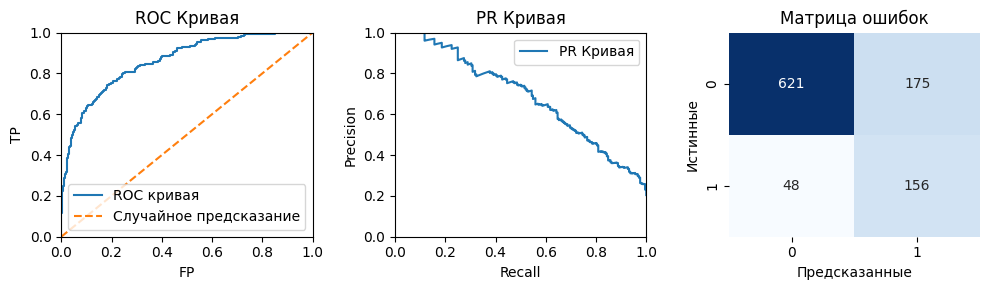

{'Balanced Accuracy': 0.7724283180608926, 'Accuracy': 0.777, 'Recall': 0.7647058823529411, 'Precision': 0.47129909365558914, 'ROC-AUC': 0.8631084343285054, 'PR-AUC': 0.6886837151302417}


In [144]:
# best_params = {'n_layers': 2, 'dropout_rate': 0.225, 'activation': 'tanh', 'units_per_layer': 214, 'learning_rate': 0.009, 'l2_reg': 0.002, 'optimizer': 'SGD', 'epochs': 58}

nn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
])

for _ in range(best_params['n_layers']):
    nn.add(
        layers.Dense(
            units=best_params['units_per_layer'],
            activation=best_params['activation'],
            kernel_regularizer=keras.regularizers.l2(best_params['l2_reg']),
        )
    )
    nn.add(layers.Dropout(best_params['dropout_rate']))
    nn.add(layers.BatchNormalization()) 

nn.add(layers.Dense(1, activation='sigmoid'))

optimizer = get_optimizer(best_params['optimizer'], best_params['learning_rate'])

nn.compile(
    optimizer=optimizer,
    loss='binary_crossentropy'
)

nn.summary()

nn.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=64,
    validation_data=(X_test, y_test),
    #callbacks=[early_stop],
    verbose=1
)

results['NN'] = evaluate_model(nn, X_test, y_test)


# Сверточная нейронная сеть

In [145]:
%%time

def objective(trial):
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 3)
    conv_filters = trial.suggest_int("conv_filters", 8, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 4)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.001)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    dense_units = trial.suggest_int("dense_units", 8, 128)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, step=0.001)
    epochs = trial.suggest_int("epochs", 10, 100)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1], 1)),
    ])

    for _ in range(n_conv_layers):
        model.add(keras.layers.Conv1D(conv_filters, kernel_size, activation=activation, padding='same'))
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(dense_units, activation=activation))
    model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    if optimizer_name == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    bal_acc = balanced_accuracy_score(y_test,y_pred)
    return bal_acc

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=TRIALS)

best_params = study.best_params
score = study.best_value

print("Best hyperparameters:", best_params)
print("Best score:", score)

[I 2024-05-18 07:27:26,643] A new study created in memory with name: no-name-4b6d98e7-f7c4-4540-8503-a858673ed093


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:28:32,301] Trial 0 finished with value: 0.7623657503202286 and parameters: {'n_conv_layers': 2, 'conv_filters': 119, 'kernel_size': 4, 'dropout_rate': 0.295, 'activation': 'relu', 'dense_units': 13, 'learning_rate': 0.003, 'epochs': 51, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.7623657503202286.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:28:38,889] Trial 1 finished with value: 0.7653217065720761 and parameters: {'n_conv_layers': 1, 'conv_filters': 114, 'kernel_size': 4, 'dropout_rate': 0.06, 'activation': 'relu', 'dense_units': 8, 'learning_rate': 0.01, 'epochs': 17, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7653217065720761.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:29:05,001] Trial 2 finished with value: 0.7709749729037343 and parameters: {'n_conv_layers': 3, 'conv_filters': 37, 'kernel_size': 2, 'dropout_rate': 0.357, 'activation': 'sigmoid', 'dense_units': 47, 'learning_rate': 0.01, 'epochs': 38, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:29:35,598] Trial 3 finished with value: 0.7670213814168884 and parameters: {'n_conv_layers': 3, 'conv_filters': 90, 'kernel_size': 3, 'dropout_rate': 0.245, 'activation': 'relu', 'dense_units': 121, 'learning_rate': 0.003, 'epochs': 23, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-05-18 07:30:44,694] Trial 4 finished with value: 0.7587939698492463 and parameters: {'n_conv_layers': 3, 'conv_filters': 69, 'kernel_size': 3, 'dropout_rate': 0.049, 'activation': 'relu', 'dense_units': 72, 'learning_rate': 0.008, 'epochs': 53, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:31:25,685] Trial 5 finished with value: 0.5 and parameters: {'n_conv_layers': 2, 'conv_filters': 83, 'kernel_size': 4, 'dropout_rate': 0.107, 'activation': 'sigmoid', 'dense_units': 55, 'learning_rate': 0.003, 'epochs': 62, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:31:43,568] Trial 6 finished with value: 0.7026554340329096 and parameters: {'n_conv_layers': 3, 'conv_filters': 8, 'kernel_size': 2, 'dropout_rate': 0.492, 'activation': 'relu', 'dense_units': 31, 'learning_rate': 0.001, 'epochs': 53, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:32:07,613] Trial 7 finished with value: 0.7553946201596216 and parameters: {'n_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 4, 'dropout_rate': 0.483, 'activation': 'sigmoid', 'dense_units': 38, 'learning_rate': 0.008, 'epochs': 64, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7709749729037343.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:32:19,608] Trial 8 finished with value: 0.7756921864223076 and parameters: {'n_conv_layers': 1, 'conv_filters': 12, 'kernel_size': 4, 'dropout_rate': 0.191, 'activation': 'tanh', 'dense_units': 56, 'learning_rate': 0.009000000000000001, 'epochs': 52, 'optimizer': 'SGD'}. Best is trial 8 with value: 0.7756921864223076.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:32:59,314] Trial 9 finished with value: 0.7750024632968765 and parameters: {'n_conv_layers': 2, 'conv_filters': 69, 'kernel_size': 2, 'dropout_rate': 0.494, 'activation': 'relu', 'dense_units': 87, 'learning_rate': 0.006, 'epochs': 60, 'optimizer': 'Adam'}. Best is trial 8 with value: 0.7756921864223076.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:33:23,303] Trial 10 finished with value: 0.7899546753374718 and parameters: {'n_conv_layers': 1, 'conv_filters': 9, 'kernel_size': 3, 'dropout_rate': 0.17300000000000001, 'activation': 'tanh', 'dense_units': 96, 'learning_rate': 0.007, 'epochs': 89, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:33:51,419] Trial 11 finished with value: 0.7791531185338457 and parameters: {'n_conv_layers': 1, 'conv_filters': 11, 'kernel_size': 3, 'dropout_rate': 0.162, 'activation': 'tanh', 'dense_units': 98, 'learning_rate': 0.007, 'epochs': 95, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:34:22,986] Trial 12 finished with value: 0.7616390777416494 and parameters: {'n_conv_layers': 1, 'conv_filters': 30, 'kernel_size': 3, 'dropout_rate': 0.155, 'activation': 'tanh', 'dense_units': 105, 'learning_rate': 0.006, 'epochs': 99, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:34:54,598] Trial 13 finished with value: 0.7666395704010247 and parameters: {'n_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 3, 'dropout_rate': 0.187, 'activation': 'tanh', 'dense_units': 94, 'learning_rate': 0.007, 'epochs': 99, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:35:21,322] Trial 14 finished with value: 0.759742339146714 and parameters: {'n_conv_layers': 1, 'conv_filters': 23, 'kernel_size': 3, 'dropout_rate': 0.292, 'activation': 'tanh', 'dense_units': 127, 'learning_rate': 0.005, 'epochs': 83, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:36:14,846] Trial 15 finished with value: 0.7619469898512169 and parameters: {'n_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 3, 'dropout_rate': 0.113, 'activation': 'tanh', 'dense_units': 106, 'learning_rate': 0.005, 'epochs': 83, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:36:40,262] Trial 16 finished with value: 0.7609493546162184 and parameters: {'n_conv_layers': 1, 'conv_filters': 20, 'kernel_size': 2, 'dropout_rate': 0.009000000000000001, 'activation': 'tanh', 'dense_units': 79, 'learning_rate': 0.007, 'epochs': 79, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-05-18 07:37:37,414] Trial 17 finished with value: 0.7694230958715145 and parameters: {'n_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 3, 'dropout_rate': 0.388, 'activation': 'tanh', 'dense_units': 108, 'learning_rate': 0.008, 'epochs': 89, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:38:01,010] Trial 18 finished with value: 0.77086412454429 and parameters: {'n_conv_layers': 1, 'conv_filters': 23, 'kernel_size': 2, 'dropout_rate': 0.244, 'activation': 'tanh', 'dense_units': 92, 'learning_rate': 0.004, 'epochs': 73, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:38:59,083] Trial 19 finished with value: 0.7613065326633166 and parameters: {'n_conv_layers': 1, 'conv_filters': 104, 'kernel_size': 3, 'dropout_rate': 0.14300000000000002, 'activation': 'tanh', 'dense_units': 113, 'learning_rate': 0.007, 'epochs': 91, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:39:22,763] Trial 20 finished with value: 0.7644226032121391 and parameters: {'n_conv_layers': 2, 'conv_filters': 12, 'kernel_size': 3, 'dropout_rate': 0.202, 'activation': 'tanh', 'dense_units': 69, 'learning_rate': 0.009000000000000001, 'epochs': 72, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:39:31,340] Trial 21 finished with value: 0.7604936446940584 and parameters: {'n_conv_layers': 1, 'conv_filters': 8, 'kernel_size': 4, 'dropout_rate': 0.193, 'activation': 'tanh', 'dense_units': 50, 'learning_rate': 0.009000000000000001, 'epochs': 45, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:39:40,040] Trial 22 finished with value: 0.7706670607941669 and parameters: {'n_conv_layers': 1, 'conv_filters': 17, 'kernel_size': 4, 'dropout_rate': 0.088, 'activation': 'tanh', 'dense_units': 61, 'learning_rate': 0.009000000000000001, 'epochs': 36, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:40:02,956] Trial 23 finished with value: 0.760555227115972 and parameters: {'n_conv_layers': 1, 'conv_filters': 31, 'kernel_size': 3, 'dropout_rate': 0.167, 'activation': 'tanh', 'dense_units': 78, 'learning_rate': 0.007, 'epochs': 71, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:40:32,706] Trial 24 finished with value: 0.7729332939205833 and parameters: {'n_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 4, 'dropout_rate': 0.226, 'activation': 'tanh', 'dense_units': 98, 'learning_rate': 0.008, 'epochs': 93, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:40:43,155] Trial 25 finished with value: 0.6985663612178539 and parameters: {'n_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 3, 'dropout_rate': 0.313, 'activation': 'sigmoid', 'dense_units': 82, 'learning_rate': 0.006, 'epochs': 30, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:41:08,625] Trial 26 finished with value: 0.7745837028278648 and parameters: {'n_conv_layers': 2, 'conv_filters': 18, 'kernel_size': 3, 'dropout_rate': 0.133, 'activation': 'tanh', 'dense_units': 62, 'learning_rate': 0.009000000000000001, 'epochs': 78, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:41:23,776] Trial 27 finished with value: 0.768092915558183 and parameters: {'n_conv_layers': 1, 'conv_filters': 59, 'kernel_size': 4, 'dropout_rate': 0.271, 'activation': 'tanh', 'dense_units': 38, 'learning_rate': 0.01, 'epochs': 44, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-18 07:41:46,246] Trial 28 finished with value: 0.7866292245541433 and parameters: {'n_conv_layers': 1, 'conv_filters': 39, 'kernel_size': 3, 'dropout_rate': 0.218, 'activation': 'tanh', 'dense_units': 116, 'learning_rate': 0.005, 'epochs': 68, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.7899546753374718.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-05-18 07:42:42,632] Trial 29 finished with value: 0.7831806089269879 and parameters: {'n_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 3, 'dropout_rate': 0.332, 'activation': 'sigmoid', 'dense_units': 120, 'learning_rate': 0.004, 'epochs': 87, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.7899546753374718.


Best hyperparameters: {'n_conv_layers': 1, 'conv_filters': 9, 'kernel_size': 3, 'dropout_rate': 0.17300000000000001, 'activation': 'tanh', 'dense_units': 96, 'learning_rate': 0.007, 'epochs': 89, 'optimizer': 'RMSprop'}
Best score: 0.7899546753374718
CPU times: user 9min 53s, sys: 9.2 s, total: 10min 2s
Wall time: 15min 15s


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 14, 9)          │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_414 (Dropout)           │ (None, 14, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 96)             │        12,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_415 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,325 (48.14 KB)

 Trainable params: 12,325 (48.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5946 - val_loss: 0.3917
Epoch 2/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5127 - val_loss: 0.4382
Epoch 3/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5126 - val_loss: 0.4554
Epoch 4/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5132 - val_loss: 0.5661
Epoch 5/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5045 - val_loss: 0.6063
Epoch 6/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5096 - val_loss: 0.5045
Epoch 7/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4957 - val_loss: 0.5502
Epoch 8/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5005 - val_loss: 0.3976
Epoch 9/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4880 - val_loss: 0.5016
Epoch 10/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5003 - val_loss: 0.4926
Epoch 11/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4859 - val_loss: 0.5323
Epoch 12/89
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4897 - val_lo

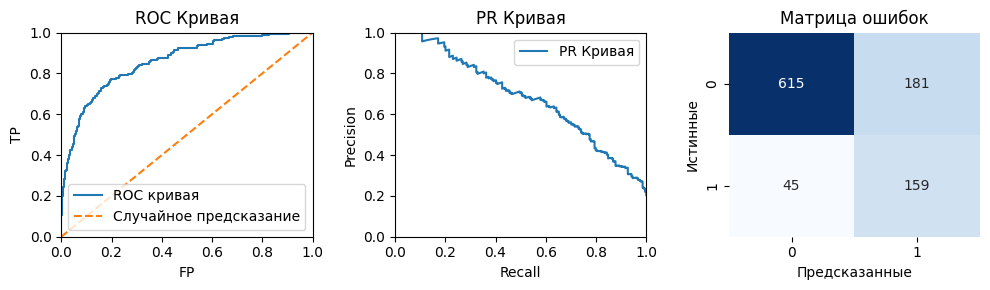

{'Balanced Accuracy': 0.7760124150162577, 'Accuracy': 0.774, 'Recall': 0.7794117647058824, 'Precision': 0.4676470588235294, 'ROC-AUC': 0.8609653660459159, 'PR-AUC': 0.6831598097836378}


In [146]:
#best_params = {'n_conv_layers': 3, 'conv_filters': 65, 'kernel_size': 2, 'dropout_rate': 0.059, 'activation': 'relu', 'dense_units': 26, 'learning_rate': 0.008, 'epochs': 99, 'optimizer': 'Adam'}

cnn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
])

for _ in range(best_params['n_conv_layers']):
    cnn.add(layers.Conv1D(
        filters=best_params['conv_filters'],
        kernel_size=best_params['kernel_size'],
        activation=best_params['activation'],
        padding='same'
    ))
    cnn.add(layers.Dropout(best_params['dropout_rate']))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(
    units=best_params['dense_units'],
    activation=best_params['activation']
))
cnn.add(layers.Dropout(best_params['dropout_rate']))
cnn.add(layers.Dense(1, activation='sigmoid'))

optimizer = get_optimizer(best_params['optimizer'], best_params['learning_rate'])

cnn.compile(
    optimizer=optimizer,
    loss='binary_crossentropy'
)

cnn.summary()

cnn.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

results['CNN'] = evaluate_model(cnn,X_test,y_test)


# Сравнение моделей

In [147]:
pd.DataFrame.from_dict(results, orient='index')

,Balanced Accuracy,Accuracy,Recall,Precision,ROC-AUC,PR-AUC
Logistic Regression,0.766147,0.767,0.764706,0.457478,0.854936,0.667166
Random Forest,0.792344,0.800,0.779412,0.506369,0.863546,0.676997
CatBoost,0.809501,0.807,0.813725,0.517134,0.878492,0.707799
XGBoost,0.803343,0.803,0.803922,0.510903,0.870517,0.676708
LGBM,0.797000,0.790,0.808824,0.491071,0.864568,0.660239
NN,0.772428,0.777,0.764706,0.471299,0.863108,0.688684
CNN,0.776012,0.774,0.779412,0.467647,0.860965,0.683160


# Сборка ансамбля

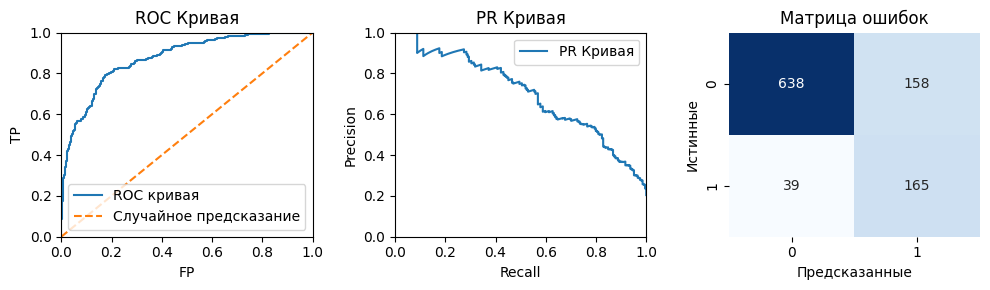

{'Balanced Accuracy': 0.8051655335501035, 'Accuracy': 0.803, 'Recall': 0.8088235294117647, 'Precision': 0.5108359133126935, 'ROC-AUC': 0.8765087693368805, 'PR-AUC': 0.6996397794142777}


array([3.51835715, 1.97009381])

In [148]:
base_models = [
    #('rf', rf),
    ('cb', cb),
    ('xgb', xgb),
    #('lgbm', lgbm),
]

logit = LogisticRegression()

ensemble = StackingClassifier(estimators=base_models, final_estimator=logit)

ensemble.fit(X_train,y_train)

_ = evaluate_model(ensemble,X_test,y_test)

ensemble.final_estimator_.coef_[0]

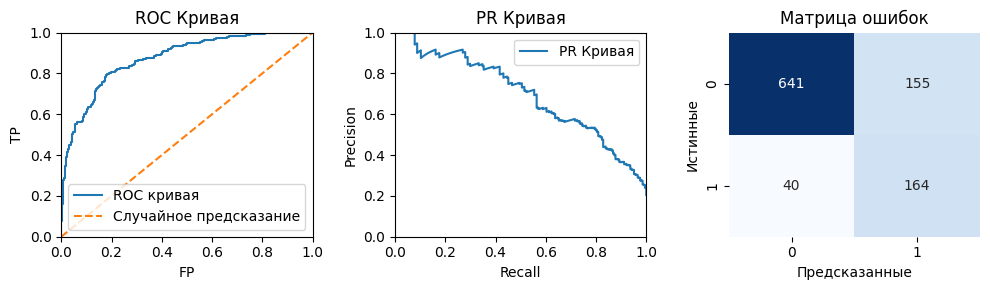

{'Balanced Accuracy': 0.8045989752684994, 'Accuracy': 0.805, 'Recall': 0.803921568627451, 'Precision': 0.5141065830721003, 'ROC-AUC': 0.875511134101882, 'PR-AUC': 0.6954105862705017}


In [149]:
ensemble = VotingClassifier(
    estimators=[
        #('rf', rf),
        ('cb', cb),
        ('xgb', xgb),
        #('lgbm', lgbm),
    ],
    voting='soft'  
)

ensemble.fit(X_train, y_train)

_ = evaluate_model(ensemble, X_test, y_test)

# Анализ ошибок

In [150]:
predictions = cb.predict_proba(X_test)

positive_probs = predictions[:, 1]

predictions = pd.DataFrame({
    'predicted_prob': positive_probs,
    'actual': y_test
})
predictions['difference'] = abs(predictions['predicted_prob'] - predictions['actual'])
predictions['certainty'] = abs(predictions['predicted_prob'] - 0.5)

predictions = pd.concat([X_test, predictions], axis=1)

predictions.sort_values(by='certainty', ascending=True).head(20)


,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,TargetAge,Geography_France,Geography_Germany,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,predicted_prob,actual,difference,certainty
RowNumber,,,,,,,,,,,,,,,,,,
7074,0.658,0.297297,0.1,0.000000,1.0,0.084436,0.578947,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.499909,0,0.499909,0.000091
4407,0.574,0.121622,0.7,0.541427,1.0,0.507081,0.236842,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.497044,0,0.497044,0.002956
7033,0.530,0.310811,0.4,0.000000,1.0,0.746408,0.605263,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.503206,0,0.503206,0.003206
9907,0.458,0.270270,0.4,0.700441,1.0,0.965687,0.526316,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.503891,0,0.503891,0.003891
5763,0.766,0.283784,0.5,0.364843,1.0,0.468902,0.552632,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.504028,0,0.504028,0.004028
9762,0.914,0.567568,0.1,0.290750,1.0,0.086727,0.894737,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.504416,0,0.504416,0.004416
187,0.760,0.283784,0.1,0.394625,0.0,0.974764,0.552632,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.504713,0,0.504713,0.004713
5202,0.438,0.243243,0.1,0.267390,0.0,0.773895,0.473684,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.495066,0,0.495066,0.004934
9966,0.554,0.202703,0.4,0.331605,0.0,0.796693,0.394737,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.504950,0,0.504950,0.004950


In [151]:
predictions[predictions['actual']==1]

,CreditScore,Age,Tenure,Balance,IsActiveMember,EstimatedSalary,TargetAge,Geography_France,Geography_Germany,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,predicted_prob,actual,difference,certainty
RowNumber,,,,,,,,,,,,,,,,,,
8694,0.542,0.432432,0.5,0.000000,0.0,0.958816,0.842105,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.666919,1,0.333081,0.166919
8524,0.680,0.486486,0.1,0.574049,1.0,0.543649,0.947368,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.867030,1,0.132970,0.367030
7826,0.488,0.067568,0.4,0.417515,0.0,0.283752,0.131579,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.362592,1,0.637408,0.137408
771,0.784,0.243243,0.2,0.517136,0.0,0.236323,0.473684,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.442207,1,0.557793,0.057793
5128,0.942,0.270270,0.8,0.000000,1.0,0.631209,0.526316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.071989,1,0.928011,0.428011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8992,0.394,0.324324,0.1,0.568770,0.0,0.431021,0.631579,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.809208,1,0.190792,0.309208
9222,0.610,0.256757,0.4,0.433892,0.0,0.397755,0.500000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.794287,1,0.205713,0.294287
3976,0.370,0.418919,0.3,0.000000,0.0,0.309074,0.815789,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.963309,1,0.036691,0.463309


# Permuatation importance

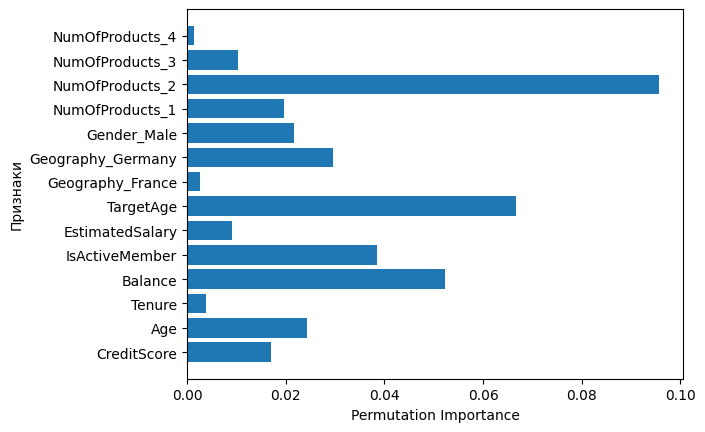

In [152]:


perm_imp = permutation_importance(
    estimator=cb,
    scoring='balanced_accuracy',
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42
)

importances = perm_imp.importances_mean
feature_names = X_test.columns

plt.barh(feature_names, importances)
plt.xlabel('Permutation Importance')
plt.ylabel('Признаки')
plt.show()

# SHAP

In [153]:
explainer = shap.TreeExplainer(cb)

shap_values = explainer.shap_values(X_test)

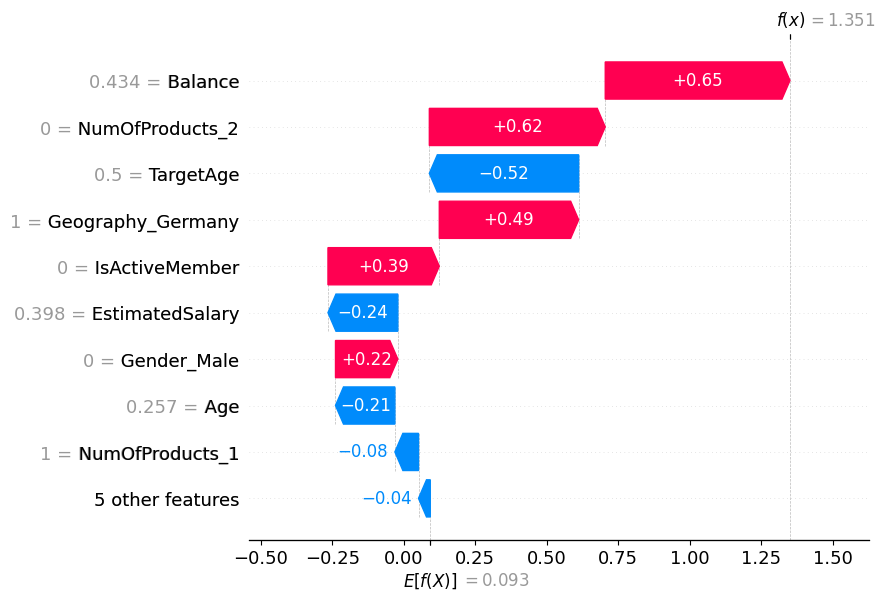

In [154]:
index = 9222

shap_values_for_row = shap_values[X_test.index.get_loc(index)]

base_value = explainer.expected_value

explanation = shap.Explanation(
    values=shap_values_for_row,
    base_values=base_value,
    data=X_test.loc[index],
    feature_names=X_test.columns.tolist()
)

shap.plots.waterfall(explanation)

plt.show()

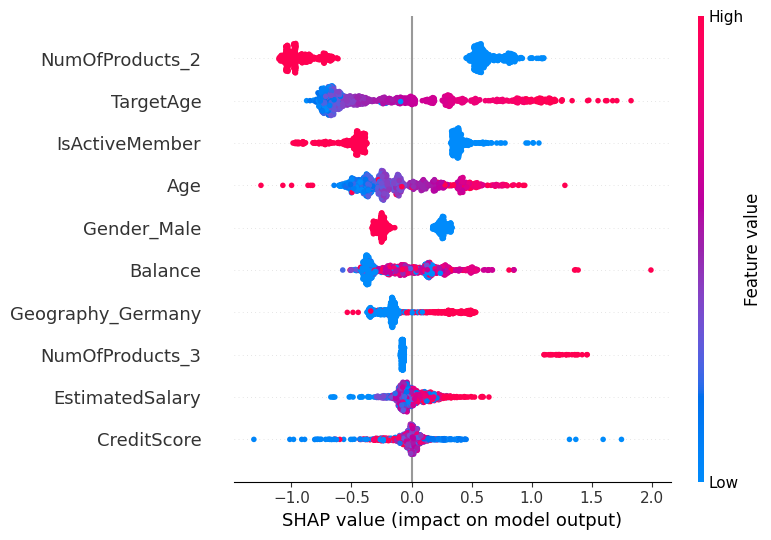

In [155]:
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

plt.show()

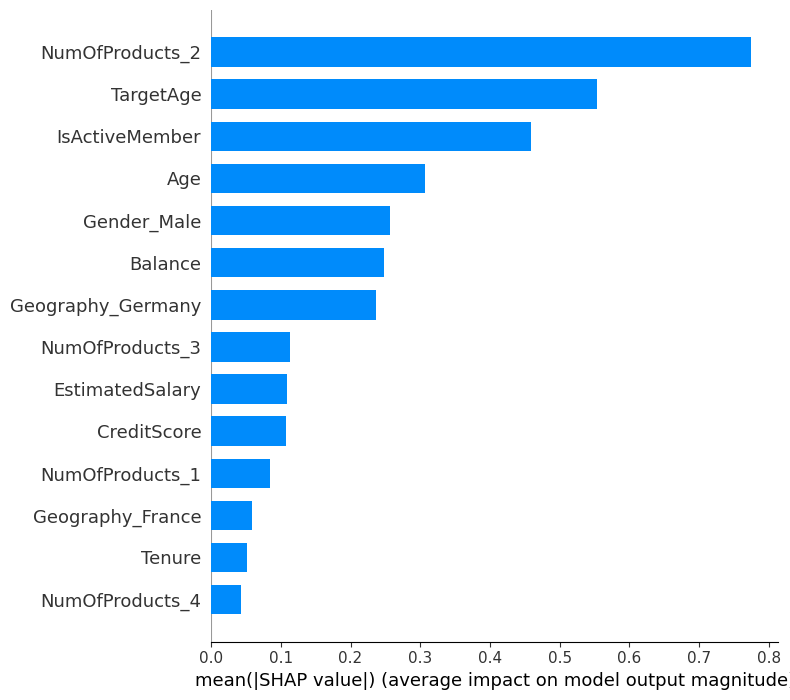

In [156]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

In [157]:
joblib.dump(encoder, 'one_hot_encoder.save') 
joblib.dump(scaler, 'min_max_scaler.save') 

['min_max_scaler.save']

In [158]:
cb.save_model("cb_model.json")